In [23]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import sys

# configure matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (13.5, 13.5) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Loading Frey Faces 

In [3]:
data_path = '/home/andrei/ml/datasets/'

In [4]:
ff = scipy.io.loadmat(data_path + 'frey_rawface.mat', squeeze_me=True, struct_as_record=False)

In [5]:
# reshape data for later convenience
img_rows, img_cols = 28, 20
ff = ff["ff"].T
# .T.reshape((-1, img_rows, img_cols))

In [6]:
ff.shape

(1965, 560)

### Visualizing Frey Faces 

In [7]:
# from http://dohmatob.github.io/research/2016/10/22/VAE.html
def show_examples(data, n=None, n_cols=20, thumbnail_cb=None):
    if n is None:
        n = len(data)    
    n_rows = int(np.ceil(n / float(n_cols)))
    figure = np.zeros((img_rows * n_rows, img_cols * n_cols))
    for k, x in enumerate(data[:n]):
        r = k // n_cols
        c = k % n_cols
        figure[r * img_rows: (r + 1) * img_rows,
               c * img_cols: (c + 1) * img_cols] = x
        if thumbnail_cb is not None:
            thumbnail_cb(locals())
        
    plt.figure(figsize=(12, 10))
    plt.imshow(figure)
    plt.axis("off")
    plt.tight_layout()

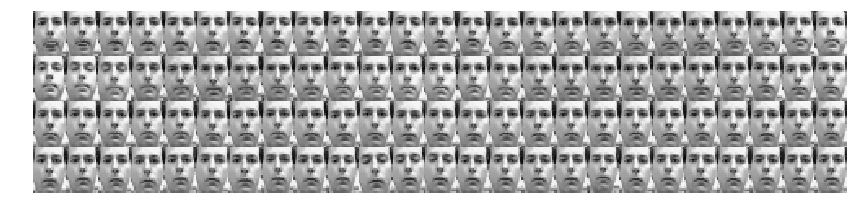

In [9]:
show_examples(ff.reshape((-1, img_rows, img_cols)), n=100, n_cols=25)

### Prepping the Data 

In [10]:
class data_reader(object):
    
    def __init__(self,X,batch_size=1):
        self.X = X
        self.num_examples = X.shape[0]
        self.batch_number = 0 
        self.batch_size = batch_size
        self.num_batches = int(np.ceil(X.shape[0] / batch_size))
    
    def next_batch(self):
        low_ix = self.batch_number*self.batch_size 
        up_ix = (self.batch_number + 1)*self.batch_size
        if up_ix >= self.X.shape[0]:
            up_ix = self.X.shape[0]
            self.batch_number = 0 # reset batch_number to zero
        else:
            self.batch_number = self.batch_number + 1
        return self.X[low_ix:up_ix,:]

In [11]:
batch_size = 100
ff_reader = data_reader(ff, batch_size)

### Training a VAE 

In [14]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected, batch_norm

In [24]:
tf.reset_default_graph()

In [25]:
# Construction phase
n_inputs = 28*20
n_hidden1 = 200
n_hidden2 = 200
n_hidden3 = 20 # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs

with tf.contrib.framework.arg_scope(
        [fully_connected],
        activation_fn = tf.nn.elu,
        weights_initializer = tf.contrib.layers.variance_scaling_initializer()):
    X = tf.placeholder(tf.float32, shape = [None, n_inputs])
    hidden1 = fully_connected(X, n_hidden1)
    hidden2 = fully_connected(hidden1, n_hidden2, activation_fn=tf.nn.tanh)
    hidden2_mean = fully_connected(hidden1, n_hidden2)
    hidden3_mean = fully_connected(hidden2, n_hidden3, activation_fn=None)
    hidden3_gamma = fully_connected(hidden2, n_hidden3, activation_fn=None)
    hidden3_sigma = tf.exp(0.5 * hidden3_gamma)
    noise1 = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
    hidden3 = hidden3_mean + hidden3_sigma * noise1
    hidden4 = fully_connected(hidden3, n_hidden4)
    hidden5 = fully_connected(hidden4, n_hidden5, activation_fn=tf.nn.tanh)
    hidden6_mean = fully_connected(hidden5, n_outputs, activation_fn=None)
    hidden6_gamma = fully_connected(hidden5, n_outputs, activation_fn=None)
    hidden6_sigma = tf.exp(0.5 * hidden6_gamma)
    noise2 = tf.random_normal(tf.shape(hidden6_sigma),stddev=2.0, dtype=tf.float32)
    outputs = hidden6_mean + hidden6_sigma * noise2

In [26]:
eps = 1e-10
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)

reconstruction_loss = 0.5 * tf.reduce_sum(tf.square((X - hidden6_mean) / (eps + tf.exp(hidden6_gamma)))
                                  + tf.log(2*np.pi) + hidden6_gamma)
cost = reconstruction_loss + latent_loss
# display_cost = tf.reduce_mean(reconstruction_loss) + tf.reduce_mean(latent_loss)

In [27]:
learning_rate = 0.0001
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(cost)

In [28]:
init = tf.global_variables_initializer()

In [ ]:
n_epochs = 10000
batch_size = 100
n_faces = 100
ff_reader = data_reader(ff, batch_size)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = ff_reader.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch = ff_reader.next_batch().astype(np.float32)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([cost,
         reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Total loss:", loss_val / X_batch.shape[0],
         "\tReconstruction loss:", reconstruction_loss_val / X_batch.shape[0],
          "\tLatent loss:", latent_loss_val / X_batch.shape[0])
    
    # generating digits
    codings_rnd = np.random.normal(size=[n_faces, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Total loss: 43460643.84 	Reconstruction loss: 43460608.0 	Latent loss: 33.7438598633
1 Total loss: 19844072.96 	Reconstruction loss: 19844037.12 	Latent loss: 35.9427099609
2 Total loss: 12282451.2 	Reconstruction loss: 12282414.08 	Latent loss: 37.2218164062
3 Total loss: 8417592.96 	Reconstruction loss: 8417553.28 	Latent loss: 39.4615087891
4 Total loss: 6188283.52 	Reconstruction loss: 6188242.56 	Latent loss: 41.0959521484
5 Total loss: 4739500.48 	Reconstruction loss: 4739458.88 	Latent loss: 41.7501123047
6 Total loss: 3782946.56 	Reconstruction loss: 3782901.76 	Latent loss: 44.8293847656
7 Total loss: 3323996.48 	Reconstruction loss: 3323950.72 	Latent loss: 45.9156640625
8 Total loss: 2814273.92 	Reconstruction loss: 2814227.2 	Latent loss: 46.827421875
9 Total loss: 2376965.28 	Reconstruction loss: 2376917.76 	Latent loss: 47.5635595703
10 Total loss: 2120447.84 	Reconstruction loss: 2120399.52 	Latent loss: 48.3521044922
11 Total loss: 1753452.8 	Reconstruction loss: 1753

97 Total loss: 72555.725 	Reconstruction loss: 72490.415 	Latent loss: 65.30984375
98 Total loss: 68460.635 	Reconstruction loss: 68395.29 	Latent loss: 65.3429785156
99 Total loss: 69990.2076923 	Reconstruction loss: 69924.7692308 	Latent loss: 65.4349158654
100 Total loss: 74586.11 	Reconstruction loss: 74520.42 	Latent loss: 65.6913671875
101 Total loss: 67581.755 	Reconstruction loss: 67516.225 	Latent loss: 65.530390625
102 Total loss: 66016.095 	Reconstruction loss: 65950.42 	Latent loss: 65.6755810547
103 Total loss: 64753.34 	Reconstruction loss: 64687.585 	Latent loss: 65.7540136719
104 Total loss: 60468.32 	Reconstruction loss: 60402.545 	Latent loss: 65.7740527344
105 Total loss: 60842.605 	Reconstruction loss: 60776.775 	Latent loss: 65.8295214844
106 Total loss: 59385.0 	Reconstruction loss: 59319.08 	Latent loss: 65.9210693359
107 Total loss: 60719.395 	Reconstruction loss: 60653.38 	Latent loss: 66.0160742188
108 Total loss: 59884.545 	Reconstruction loss: 59818.485 	Lat

193 Total loss: 20926.09375 	Reconstruction loss: 20855.21125 	Latent loss: 70.8823144531
194 Total loss: 21926.2175 	Reconstruction loss: 21855.46 	Latent loss: 70.7584130859
195 Total loss: 19351.415 	Reconstruction loss: 19280.8025 	Latent loss: 70.6123974609
196 Total loss: 19283.81625 	Reconstruction loss: 19213.21 	Latent loss: 70.6063720703
197 Total loss: 18973.9975 	Reconstruction loss: 18903.375 	Latent loss: 70.62234375
198 Total loss: 17938.615 	Reconstruction loss: 17867.9975 	Latent loss: 70.6177294922
199 Total loss: 18615.8192308 	Reconstruction loss: 18545.1384615 	Latent loss: 70.6805063101
200 Total loss: 19816.08375 	Reconstruction loss: 19745.165 	Latent loss: 70.9190625
201 Total loss: 18146.40625 	Reconstruction loss: 18075.6975 	Latent loss: 70.7083398437
202 Total loss: 17825.06375 	Reconstruction loss: 17754.23 	Latent loss: 70.8343164062
203 Total loss: 17749.11125 	Reconstruction loss: 17678.24 	Latent loss: 70.8718457031
204 Total loss: 16710.6525 	Reconstr

287 Total loss: 8269.51625 	Reconstruction loss: 8195.9075 	Latent loss: 73.6085058594
288 Total loss: 8239.551875 	Reconstruction loss: 8165.92625 	Latent loss: 73.6254443359
289 Total loss: 8100.4325 	Reconstruction loss: 8026.748125 	Latent loss: 73.6844091797
290 Total loss: 8051.85125 	Reconstruction loss: 7978.1475 	Latent loss: 73.7035107422
291 Total loss: 7647.38125 	Reconstruction loss: 7573.59875 	Latent loss: 73.7827539062
292 Total loss: 8316.080625 	Reconstruction loss: 8242.31125 	Latent loss: 73.769296875
293 Total loss: 8430.73125 	Reconstruction loss: 8356.518125 	Latent loss: 74.2132568359
294 Total loss: 8844.485625 	Reconstruction loss: 8770.41375 	Latent loss: 74.0719091797
295 Total loss: 7903.931875 	Reconstruction loss: 7830.025625 	Latent loss: 73.906015625
296 Total loss: 7862.141875 	Reconstruction loss: 7788.2625 	Latent loss: 73.8793359375
297 Total loss: 7778.128125 	Reconstruction loss: 7704.239375 	Latent loss: 73.8885644531
298 Total loss: 7396.608125 

380 Total loss: 4838.8503125 	Reconstruction loss: 4762.8775 	Latent loss: 75.9727734375
381 Total loss: 4514.245 	Reconstruction loss: 4438.5525 	Latent loss: 75.6923876953
382 Total loss: 4474.1278125 	Reconstruction loss: 4398.3028125 	Latent loss: 75.8251416016
383 Total loss: 4466.536875 	Reconstruction loss: 4390.725625 	Latent loss: 75.8111376953
384 Total loss: 4335.1259375 	Reconstruction loss: 4259.34875 	Latent loss: 75.7772998047
385 Total loss: 4330.8953125 	Reconstruction loss: 4255.110625 	Latent loss: 75.7845556641
386 Total loss: 4242.3334375 	Reconstruction loss: 4166.4984375 	Latent loss: 75.8349755859
387 Total loss: 4328.9521875 	Reconstruction loss: 4253.0859375 	Latent loss: 75.8663867187
388 Total loss: 4328.97125 	Reconstruction loss: 4253.088125 	Latent loss: 75.8831396484
389 Total loss: 4271.8209375 	Reconstruction loss: 4195.8934375 	Latent loss: 75.9274462891
390 Total loss: 4268.73375 	Reconstruction loss: 4192.8 	Latent loss: 75.9337841797
391 Total loss

472 Total loss: 3147.520625 	Reconstruction loss: 3070.693125 	Latent loss: 76.82734375
473 Total loss: 3166.34375 	Reconstruction loss: 3089.1234375 	Latent loss: 77.2201660156
474 Total loss: 3243.403125 	Reconstruction loss: 3166.3146875 	Latent loss: 77.0885058594
475 Total loss: 3068.5521875 	Reconstruction loss: 2991.663125 	Latent loss: 76.8891064453
476 Total loss: 3058.2103125 	Reconstruction loss: 2981.37875 	Latent loss: 76.8314501953
477 Total loss: 3048.2925 	Reconstruction loss: 2971.47 	Latent loss: 76.8225683594
478 Total loss: 2978.595 	Reconstruction loss: 2901.8259375 	Latent loss: 76.7691015625
479 Total loss: 3035.00168269 	Reconstruction loss: 2958.20456731 	Latent loss: 76.7971980168
480 Total loss: 3143.295625 	Reconstruction loss: 3066.265 	Latent loss: 77.0307666016
481 Total loss: 3004.944375 	Reconstruction loss: 2928.2 	Latent loss: 76.7443212891
482 Total loss: 2995.61875 	Reconstruction loss: 2918.76375 	Latent loss: 76.8549414063
483 Total loss: 2992.966

563 Total loss: 2528.5990625 	Reconstruction loss: 2452.63015625 	Latent loss: 75.9689013672
564 Total loss: 2501.8325 	Reconstruction loss: 2425.9603125 	Latent loss: 75.8722119141
565 Total loss: 2501.01 	Reconstruction loss: 2425.15109375 	Latent loss: 75.8588964844
566 Total loss: 2481.11125 	Reconstruction loss: 2405.24484375 	Latent loss: 75.8663818359
567 Total loss: 2504.23203125 	Reconstruction loss: 2428.37921875 	Latent loss: 75.8528710937
568 Total loss: 2503.51765625 	Reconstruction loss: 2427.70109375 	Latent loss: 75.8165429687
569 Total loss: 2492.6821875 	Reconstruction loss: 2416.92796875 	Latent loss: 75.7541699219
570 Total loss: 2495.07203125 	Reconstruction loss: 2419.28359375 	Latent loss: 75.7884472656
571 Total loss: 2460.62015625 	Reconstruction loss: 2384.81 	Latent loss: 75.8101953125
572 Total loss: 2519.83796875 	Reconstruction loss: 2444.1309375 	Latent loss: 75.70703125
573 Total loss: 2529.866875 	Reconstruction loss: 2453.8715625 	Latent loss: 75.99533

653 Total loss: 2329.20125 	Reconstruction loss: 2257.50390625 	Latent loss: 71.6974023437
654 Total loss: 2349.48671875 	Reconstruction loss: 2277.89296875 	Latent loss: 71.59375
655 Total loss: 2301.3925 	Reconstruction loss: 2230.0821875 	Latent loss: 71.3103466797
656 Total loss: 2300.17859375 	Reconstruction loss: 2228.955 	Latent loss: 71.2235888672
657 Total loss: 2298.04234375 	Reconstruction loss: 2226.918125 	Latent loss: 71.1241601562
658 Total loss: 2281.24546875 	Reconstruction loss: 2210.2390625 	Latent loss: 71.0063476562
659 Total loss: 2297.91899038 	Reconstruction loss: 2226.975 	Latent loss: 70.9439603365
660 Total loss: 2331.00078125 	Reconstruction loss: 2259.95609375 	Latent loss: 71.0446289062
661 Total loss: 2292.489375 	Reconstruction loss: 2221.79515625 	Latent loss: 70.6942675781
662 Total loss: 2290.5634375 	Reconstruction loss: 2219.8821875 	Latent loss: 70.6812695312
663 Total loss: 2290.94734375 	Reconstruction loss: 2220.3509375 	Latent loss: 70.59637695

743 Total loss: 2204.29234375 	Reconstruction loss: 2143.9284375 	Latent loss: 60.3638964844
744 Total loss: 2194.82296875 	Reconstruction loss: 2134.66765625 	Latent loss: 60.1552392578
745 Total loss: 2194.64515625 	Reconstruction loss: 2134.655625 	Latent loss: 59.9895361328
746 Total loss: 2184.53875 	Reconstruction loss: 2124.6603125 	Latent loss: 59.8784423828
747 Total loss: 2196.92328125 	Reconstruction loss: 2137.25390625 	Latent loss: 59.6693066406
748 Total loss: 2196.12546875 	Reconstruction loss: 2136.6021875 	Latent loss: 59.5232128906
749 Total loss: 2192.34625 	Reconstruction loss: 2133.01125 	Latent loss: 59.3350390625
750 Total loss: 2194.10671875 	Reconstruction loss: 2134.915 	Latent loss: 59.1917480469
751 Total loss: 2182.7540625 	Reconstruction loss: 2123.709375 	Latent loss: 59.0446386719
752 Total loss: 2203.82640625 	Reconstruction loss: 2144.99265625 	Latent loss: 58.8337841797
753 Total loss: 2213.45828125 	Reconstruction loss: 2154.7746875 	Latent loss: 58.

833 Total loss: 2154.895625 	Reconstruction loss: 2112.3315625 	Latent loss: 42.5640527344
834 Total loss: 2166.1078125 	Reconstruction loss: 2123.6059375 	Latent loss: 42.5019042969
835 Total loss: 2130.23796875 	Reconstruction loss: 2087.979375 	Latent loss: 42.2586035156
836 Total loss: 2132.5684375 	Reconstruction loss: 2090.5290625 	Latent loss: 42.0393212891
837 Total loss: 2129.90140625 	Reconstruction loss: 2088.05 	Latent loss: 41.8514697266
838 Total loss: 2121.2490625 	Reconstruction loss: 2079.6153125 	Latent loss: 41.6337988281
839 Total loss: 2132.72548077 	Reconstruction loss: 2091.28485577 	Latent loss: 41.4405048077
840 Total loss: 2157.5259375 	Reconstruction loss: 2116.210625 	Latent loss: 41.3153759766
841 Total loss: 2129.459375 	Reconstruction loss: 2088.495 	Latent loss: 40.9643701172
842 Total loss: 2129.9828125 	Reconstruction loss: 2089.119375 	Latent loss: 40.8634350586
843 Total loss: 2132.23328125 	Reconstruction loss: 2091.60140625 	Latent loss: 40.6318627

923 Total loss: 2077.696875 	Reconstruction loss: 2048.5728125 	Latent loss: 29.1239892578
924 Total loss: 2074.37359375 	Reconstruction loss: 2045.2778125 	Latent loss: 29.0958544922
925 Total loss: 2068.13296875 	Reconstruction loss: 2039.2359375 	Latent loss: 28.8970703125
926 Total loss: 2059.17625 	Reconstruction loss: 2030.3171875 	Latent loss: 28.8590991211
927 Total loss: 2073.85546875 	Reconstruction loss: 2045.111875 	Latent loss: 28.7436645508
928 Total loss: 2071.0090625 	Reconstruction loss: 2042.40671875 	Latent loss: 28.6023828125
929 Total loss: 2068.49484375 	Reconstruction loss: 2040.013125 	Latent loss: 28.4816796875
930 Total loss: 2072.04421875 	Reconstruction loss: 2043.6290625 	Latent loss: 28.4151464844
931 Total loss: 2061.78484375 	Reconstruction loss: 2033.445625 	Latent loss: 28.3391601562
932 Total loss: 2076.70203125 	Reconstruction loss: 2048.50265625 	Latent loss: 28.1993798828
933 Total loss: 2091.47453125 	Reconstruction loss: 2063.38046875 	Latent los

1013 Total loss: 2034.0134375 	Reconstruction loss: 2012.23125 	Latent loss: 21.7821289063
1014 Total loss: 2046.51578125 	Reconstruction loss: 2024.81328125 	Latent loss: 21.7025219727
1015 Total loss: 1998.81484375 	Reconstruction loss: 1977.26375 	Latent loss: 21.5510546875
1016 Total loss: 2001.038125 	Reconstruction loss: 1979.5559375 	Latent loss: 21.4821899414
1017 Total loss: 1999.10546875 	Reconstruction loss: 1977.73171875 	Latent loss: 21.3737329102
1018 Total loss: 1988.5509375 	Reconstruction loss: 1967.328125 	Latent loss: 21.2228417969
1019 Total loss: 2000.71117788 	Reconstruction loss: 1979.56105769 	Latent loss: 21.1501126803
1020 Total loss: 2037.19171875 	Reconstruction loss: 2016.0259375 	Latent loss: 21.165715332
1021 Total loss: 1999.49015625 	Reconstruction loss: 1978.4484375 	Latent loss: 21.0416625977
1022 Total loss: 1997.8978125 	Reconstruction loss: 1976.9378125 	Latent loss: 20.9600195313
1023 Total loss: 2002.005 	Reconstruction loss: 1981.0653125 	Latent

1102 Total loss: 1926.51828125 	Reconstruction loss: 1910.25859375 	Latent loss: 16.2597607422
1103 Total loss: 1935.32015625 	Reconstruction loss: 1919.15984375 	Latent loss: 16.1603308105
1104 Total loss: 1949.60859375 	Reconstruction loss: 1933.3953125 	Latent loss: 16.2132409668
1105 Total loss: 1921.3025 	Reconstruction loss: 1905.3290625 	Latent loss: 15.9733728027
1106 Total loss: 1906.5571875 	Reconstruction loss: 1890.65859375 	Latent loss: 15.8986328125
1107 Total loss: 1934.7575 	Reconstruction loss: 1918.765625 	Latent loss: 15.9917980957
1108 Total loss: 1925.4865625 	Reconstruction loss: 1909.4984375 	Latent loss: 15.988145752
1109 Total loss: 1920.43828125 	Reconstruction loss: 1904.70765625 	Latent loss: 15.7306018066
1110 Total loss: 1936.3378125 	Reconstruction loss: 1920.4503125 	Latent loss: 15.8874304199
1111 Total loss: 1920.45109375 	Reconstruction loss: 1904.6246875 	Latent loss: 15.826472168
1112 Total loss: 1932.10421875 	Reconstruction loss: 1916.3634375 	Lat

1191 Total loss: 1852.83015625 	Reconstruction loss: 1840.736875 	Latent loss: 12.0932788086
1192 Total loss: 1857.17484375 	Reconstruction loss: 1845.265625 	Latent loss: 11.909284668
1193 Total loss: 1889.8021875 	Reconstruction loss: 1877.635 	Latent loss: 12.1671948242
1194 Total loss: 1904.139375 	Reconstruction loss: 1892.1646875 	Latent loss: 11.9746276855
1195 Total loss: 1829.36328125 	Reconstruction loss: 1817.36265625 	Latent loss: 12.0006982422
1196 Total loss: 1827.86625 	Reconstruction loss: 1816.14546875 	Latent loss: 11.7207312012
1197 Total loss: 1829.39328125 	Reconstruction loss: 1818.1784375 	Latent loss: 11.2149194336
1198 Total loss: 1817.6909375 	Reconstruction loss: 1806.3478125 	Latent loss: 11.3430554199
1199 Total loss: 1832.4796875 	Reconstruction loss: 1821.153125 	Latent loss: 11.3265850361
1200 Total loss: 1892.5415625 	Reconstruction loss: 1881.01375 	Latent loss: 11.5277758789
1201 Total loss: 1832.9159375 	Reconstruction loss: 1821.70765625 	Latent los

1280 Total loss: 1835.34125 	Reconstruction loss: 1825.9465625 	Latent loss: 9.39475646973
1281 Total loss: 1765.2103125 	Reconstruction loss: 1755.57875 	Latent loss: 9.63161315918
1282 Total loss: 1768.34359375 	Reconstruction loss: 1758.798125 	Latent loss: 9.54546508789
1283 Total loss: 1781.5903125 	Reconstruction loss: 1771.911875 	Latent loss: 9.67841491699
1284 Total loss: 1836.79734375 	Reconstruction loss: 1827.110625 	Latent loss: 9.68672241211
1285 Total loss: 1770.9825 	Reconstruction loss: 1761.08515625 	Latent loss: 9.89729736328
1286 Total loss: 1744.849375 	Reconstruction loss: 1735.22734375 	Latent loss: 9.62208496094
1287 Total loss: 1793.96234375 	Reconstruction loss: 1784.56921875 	Latent loss: 9.39306335449
1288 Total loss: 1766.584375 	Reconstruction loss: 1757.239375 	Latent loss: 9.34502380371
1289 Total loss: 1769.84140625 	Reconstruction loss: 1760.50390625 	Latent loss: 9.33755371094
1290 Total loss: 1802.73421875 	Reconstruction loss: 1793.42375 	Latent los

1369 Total loss: 1715.16703125 	Reconstruction loss: 1706.14484375 	Latent loss: 9.02219726562
1370 Total loss: 1757.88109375 	Reconstruction loss: 1749.50765625 	Latent loss: 8.3733996582
1371 Total loss: 1730.38953125 	Reconstruction loss: 1722.5803125 	Latent loss: 7.80919921875
1372 Total loss: 1731.826875 	Reconstruction loss: 1724.11640625 	Latent loss: 7.71049072266
1373 Total loss: 1768.73765625 	Reconstruction loss: 1761.15203125 	Latent loss: 7.5856060791
1374 Total loss: 1790.030625 	Reconstruction loss: 1782.32625 	Latent loss: 7.70431762695
1375 Total loss: 1685.32640625 	Reconstruction loss: 1677.7815625 	Latent loss: 7.54487854004
1376 Total loss: 1680.51328125 	Reconstruction loss: 1673.0978125 	Latent loss: 7.4154284668
1377 Total loss: 1685.60859375 	Reconstruction loss: 1678.3428125 	Latent loss: 7.26583557129
1378 Total loss: 1672.4725 	Reconstruction loss: 1665.04546875 	Latent loss: 7.42703063965
1379 Total loss: 1691.73689904 	Reconstruction loss: 1683.62319712 	

1458 Total loss: 1628.56078125 	Reconstruction loss: 1620.9425 	Latent loss: 7.61825317383
1459 Total loss: 1648.16165865 	Reconstruction loss: 1639.06622596 	Latent loss: 9.09547400841
1460 Total loss: 1748.12703125 	Reconstruction loss: 1739.3375 	Latent loss: 8.78952697754
1461 Total loss: 1658.2778125 	Reconstruction loss: 1650.1065625 	Latent loss: 8.17117675781
1462 Total loss: 1654.64640625 	Reconstruction loss: 1647.066875 	Latent loss: 7.57949707031
1463 Total loss: 1671.30953125 	Reconstruction loss: 1664.1784375 	Latent loss: 7.13116638184
1464 Total loss: 1762.11546875 	Reconstruction loss: 1755.133125 	Latent loss: 6.98241210937
1465 Total loss: 1668.11953125 	Reconstruction loss: 1659.83984375 	Latent loss: 8.27965087891
1466 Total loss: 1636.20046875 	Reconstruction loss: 1627.98078125 	Latent loss: 8.21973449707
1467 Total loss: 1696.574375 	Reconstruction loss: 1688.9046875 	Latent loss: 7.66962280273
1468 Total loss: 1659.82203125 	Reconstruction loss: 1652.7078125 	L

1547 Total loss: 1684.0846875 	Reconstruction loss: 1665.160625 	Latent loss: 18.9241040039
1548 Total loss: 1645.820625 	Reconstruction loss: 1627.0653125 	Latent loss: 18.7552453613
1549 Total loss: 1648.89796875 	Reconstruction loss: 1630.31046875 	Latent loss: 18.5875170898
1550 Total loss: 1708.2396875 	Reconstruction loss: 1689.799375 	Latent loss: 18.4403771973
1551 Total loss: 1681.2996875 	Reconstruction loss: 1663.014375 	Latent loss: 18.2853442383
1552 Total loss: 1673.68109375 	Reconstruction loss: 1655.59046875 	Latent loss: 18.0906066895
1553 Total loss: 1710.526875 	Reconstruction loss: 1692.6 	Latent loss: 17.9269067383
1554 Total loss: 1734.9459375 	Reconstruction loss: 1717.1790625 	Latent loss: 17.7669335938
1555 Total loss: 1613.691875 	Reconstruction loss: 1596.0896875 	Latent loss: 17.6022192383
1556 Total loss: 1603.88390625 	Reconstruction loss: 1586.4428125 	Latent loss: 17.4411682129
1557 Total loss: 1613.093125 	Reconstruction loss: 1595.8121875 	Latent loss:

1636 Total loss: 1574.64671875 	Reconstruction loss: 1567.53921875 	Latent loss: 7.10749450684
1637 Total loss: 1586.0696875 	Reconstruction loss: 1579.00875 	Latent loss: 7.06091125488
1638 Total loss: 1574.490625 	Reconstruction loss: 1566.91796875 	Latent loss: 7.57264038086
1639 Total loss: 1594.70889423 	Reconstruction loss: 1585.66370192 	Latent loss: 9.04521296575
1640 Total loss: 1711.4728125 	Reconstruction loss: 1702.33375 	Latent loss: 9.13909973145
1641 Total loss: 1593.781875 	Reconstruction loss: 1584.7565625 	Latent loss: 9.02532165527
1642 Total loss: 1608.07890625 	Reconstruction loss: 1599.1940625 	Latent loss: 8.88486022949
1643 Total loss: 1625.1078125 	Reconstruction loss: 1616.3653125 	Latent loss: 8.74253967285
1644 Total loss: 1743.7240625 	Reconstruction loss: 1735.10390625 	Latent loss: 8.6201751709
1645 Total loss: 1646.82609375 	Reconstruction loss: 1638.35625 	Latent loss: 8.46986694336
1646 Total loss: 1591.41953125 	Reconstruction loss: 1583.065 	Latent l

1725 Total loss: 1640.52484375 	Reconstruction loss: 1634.68265625 	Latent loss: 5.84219238281
1726 Total loss: 1582.79640625 	Reconstruction loss: 1576.96 	Latent loss: 5.83633239746
1727 Total loss: 1651.025 	Reconstruction loss: 1640.5321875 	Latent loss: 10.4928088379
1728 Total loss: 1610.61203125 	Reconstruction loss: 1602.25203125 	Latent loss: 8.36005554199
1729 Total loss: 1622.1621875 	Reconstruction loss: 1610.33734375 	Latent loss: 11.8249072266
1730 Total loss: 1686.6746875 	Reconstruction loss: 1670.24671875 	Latent loss: 16.4279870605
1731 Total loss: 1661.90765625 	Reconstruction loss: 1647.71875 	Latent loss: 14.1888586426
1732 Total loss: 1652.67703125 	Reconstruction loss: 1639.825 	Latent loss: 12.8520837402
1733 Total loss: 1685.369375 	Reconstruction loss: 1668.34328125 	Latent loss: 17.0261083984
1734 Total loss: 1703.724375 	Reconstruction loss: 1684.2984375 	Latent loss: 19.4259594727
1735 Total loss: 1607.50421875 	Reconstruction loss: 1589.6403125 	Latent los

1814 Total loss: 1720.26953125 	Reconstruction loss: 1690.9584375 	Latent loss: 29.3111279297
1815 Total loss: 1597.066875 	Reconstruction loss: 1567.78015625 	Latent loss: 29.2866650391
1816 Total loss: 1585.62265625 	Reconstruction loss: 1556.360625 	Latent loss: 29.262019043
1817 Total loss: 1598.4596875 	Reconstruction loss: 1569.2225 	Latent loss: 29.2371850586
1818 Total loss: 1585.8290625 	Reconstruction loss: 1556.616875 	Latent loss: 29.2121459961
1819 Total loss: 1603.96598558 	Reconstruction loss: 1574.77908654 	Latent loss: 29.1869253305
1820 Total loss: 1729.86109375 	Reconstruction loss: 1700.69953125 	Latent loss: 29.1614892578
1821 Total loss: 1603.51765625 	Reconstruction loss: 1574.38171875 	Latent loss: 29.1359179688
1822 Total loss: 1620.44265625 	Reconstruction loss: 1591.3325 	Latent loss: 29.1101538086
1823 Total loss: 1636.4109375 	Reconstruction loss: 1607.32671875 	Latent loss: 29.0842260742
1824 Total loss: 1759.0746875 	Reconstruction loss: 1730.0165625 	Lat

1903 Total loss: 1632.2378125 	Reconstruction loss: 1605.94859375 	Latent loss: 26.2892480469
1904 Total loss: 1756.49828125 	Reconstruction loss: 1730.2540625 	Latent loss: 26.2441577148
1905 Total loss: 1659.53140625 	Reconstruction loss: 1633.33265625 	Latent loss: 26.1987817383
1906 Total loss: 1600.75 	Reconstruction loss: 1574.596875 	Latent loss: 26.153125
1907 Total loss: 1664.4025 	Reconstruction loss: 1638.2953125 	Latent loss: 26.1071875
1908 Total loss: 1625.31109375 	Reconstruction loss: 1599.25015625 	Latent loss: 26.0609619141
1909 Total loss: 1627.2134375 	Reconstruction loss: 1601.1990625 	Latent loss: 26.014453125
1910 Total loss: 1697.51203125 	Reconstruction loss: 1671.544375 	Latent loss: 25.9676611328
1911 Total loss: 1675.59109375 	Reconstruction loss: 1649.67046875 	Latent loss: 25.9206030273
1912 Total loss: 1664.45828125 	Reconstruction loss: 1638.585 	Latent loss: 25.8732592773
1913 Total loss: 1691.7653125 	Reconstruction loss: 1665.9396875 	Latent loss: 25.

1992 Total loss: 1659.6928125 	Reconstruction loss: 1638.5784375 	Latent loss: 21.1143432617
1993 Total loss: 1687.05 	Reconstruction loss: 1666.0075 	Latent loss: 21.0425097656
1994 Total loss: 1712.29625 	Reconstruction loss: 1691.3259375 	Latent loss: 20.970378418
1995 Total loss: 1586.57234375 	Reconstruction loss: 1565.674375 	Latent loss: 20.8979394531
1996 Total loss: 1575.23359375 	Reconstruction loss: 1554.4084375 	Latent loss: 20.8251879883
1997 Total loss: 1588.03125 	Reconstruction loss: 1567.2790625 	Latent loss: 20.7521362305
1998 Total loss: 1575.35296875 	Reconstruction loss: 1554.67421875 	Latent loss: 20.6787719727
1999 Total loss: 1593.74098558 	Reconstruction loss: 1573.1359375 	Latent loss: 20.6051044171
2000 Total loss: 1722.59875 	Reconstruction loss: 1702.06765625 	Latent loss: 20.5311303711
2001 Total loss: 1593.28109375 	Reconstruction loss: 1572.8240625 	Latent loss: 20.4570056152
2002 Total loss: 1610.18015625 	Reconstruction loss: 1589.7975 	Latent loss: 20

2081 Total loss: 1586.43375 	Reconstruction loss: 1572.6525 	Latent loss: 13.7812561035
2082 Total loss: 1603.30796875 	Reconstruction loss: 1589.615625 	Latent loss: 13.6922839355
2083 Total loss: 1619.37640625 	Reconstruction loss: 1605.773125 	Latent loss: 13.6032861328
2084 Total loss: 1743.585 	Reconstruction loss: 1730.07078125 	Latent loss: 13.5142492676
2085 Total loss: 1646.44265625 	Reconstruction loss: 1633.0175 	Latent loss: 13.4252075195
2086 Total loss: 1587.28046875 	Reconstruction loss: 1573.944375 	Latent loss: 13.3361499023
2087 Total loss: 1651.1103125 	Reconstruction loss: 1637.863125 	Latent loss: 13.2471459961
2088 Total loss: 1611.915625 	Reconstruction loss: 1598.7575 	Latent loss: 13.1581079102
2089 Total loss: 1613.8375 	Reconstruction loss: 1600.7684375 	Latent loss: 13.0690600586
2090 Total loss: 1684.36953125 	Reconstruction loss: 1671.38953125 	Latent loss: 12.9800048828
2091 Total loss: 1662.3425 	Reconstruction loss: 1649.4515625 	Latent loss: 12.8909594

2170 Total loss: 1677.8125 	Reconstruction loss: 1671.18375 	Latent loss: 6.62867797852
2171 Total loss: 1655.8159375 	Reconstruction loss: 1649.2534375 	Latent loss: 6.56255126953
2172 Total loss: 1645.32953125 	Reconstruction loss: 1638.7315625 	Latent loss: 6.5979284668
2173 Total loss: 1672.76859375 	Reconstruction loss: 1666.165625 	Latent loss: 6.60297180176
2174 Total loss: 1698.05296875 	Reconstruction loss: 1691.4759375 	Latent loss: 6.57704101563
2175 Total loss: 1571.86890625 	Reconstruction loss: 1565.27125 	Latent loss: 6.59765930176
2176 Total loss: 1560.8009375 	Reconstruction loss: 1554.1384375 	Latent loss: 6.66250732422
2177 Total loss: 1573.64421875 	Reconstruction loss: 1567.00484375 	Latent loss: 6.6393963623
2178 Total loss: 1560.8009375 	Reconstruction loss: 1554.2340625 	Latent loss: 6.56694152832
2179 Total loss: 1579.08305288 	Reconstruction loss: 1572.59471154 	Latent loss: 6.4883577787
2180 Total loss: 1708.62078125 	Reconstruction loss: 1702.2109375 	Latent

2259 Total loss: 1578.15540865 	Reconstruction loss: 1572.78028846 	Latent loss: 5.37513615535
2260 Total loss: 1707.90375 	Reconstruction loss: 1702.58875 	Latent loss: 5.31492797852
2261 Total loss: 1577.41125 	Reconstruction loss: 1572.19109375 	Latent loss: 5.22018859863
2262 Total loss: 1595.554375 	Reconstruction loss: 1589.71875 	Latent loss: 5.83557861328
2263 Total loss: 1611.43171875 	Reconstruction loss: 1605.5465625 	Latent loss: 5.88522033691
2264 Total loss: 1735.3234375 	Reconstruction loss: 1729.5253125 	Latent loss: 5.79811218262
2265 Total loss: 1638.1428125 	Reconstruction loss: 1632.40484375 	Latent loss: 5.73800964355
2266 Total loss: 1579.6496875 	Reconstruction loss: 1573.6340625 	Latent loss: 6.01562072754
2267 Total loss: 1644.10546875 	Reconstruction loss: 1637.2184375 	Latent loss: 6.8870715332
2268 Total loss: 1605.106875 	Reconstruction loss: 1598.25625 	Latent loss: 6.85065734863
2269 Total loss: 1607.0565625 	Reconstruction loss: 1600.3696875 	Latent loss

2348 Total loss: 1610.29265625 	Reconstruction loss: 1598.1578125 	Latent loss: 12.1348754883
2349 Total loss: 1612.2640625 	Reconstruction loss: 1600.24484375 	Latent loss: 12.019161377
2350 Total loss: 1682.9346875 	Reconstruction loss: 1671.030625 	Latent loss: 11.9040283203
2351 Total loss: 1660.8296875 	Reconstruction loss: 1649.04015625 	Latent loss: 11.7894787598
2352 Total loss: 1651.1315625 	Reconstruction loss: 1639.45609375 	Latent loss: 11.6755053711
2353 Total loss: 1677.6084375 	Reconstruction loss: 1666.04625 	Latent loss: 11.562109375
2354 Total loss: 1702.96515625 	Reconstruction loss: 1691.5159375 	Latent loss: 11.4492810059
2355 Total loss: 1576.29265625 	Reconstruction loss: 1564.955625 	Latent loss: 11.3370336914
2356 Total loss: 1564.9165625 	Reconstruction loss: 1553.69125 	Latent loss: 11.2253540039
2357 Total loss: 1577.816875 	Reconstruction loss: 1566.70265625 	Latent loss: 11.1142529297
2358 Total loss: 1564.96484375 	Reconstruction loss: 1553.96109375 	Late

2437 Total loss: 1572.07875 	Reconstruction loss: 1566.76140625 	Latent loss: 5.31732910156
2438 Total loss: 1559.8384375 	Reconstruction loss: 1554.265625 	Latent loss: 5.57275756836
2439 Total loss: 1578.09302885 	Reconstruction loss: 1572.56033654 	Latent loss: 5.53266132061
2440 Total loss: 1707.9525 	Reconstruction loss: 1702.4415625 	Latent loss: 5.51094543457
2441 Total loss: 1578.05765625 	Reconstruction loss: 1572.378125 	Latent loss: 5.67947387695
2442 Total loss: 1595.1746875 	Reconstruction loss: 1589.558125 	Latent loss: 5.61657409668
2443 Total loss: 1610.955625 	Reconstruction loss: 1605.42578125 	Latent loss: 5.52989013672
2444 Total loss: 1735.17109375 	Reconstruction loss: 1729.5834375 	Latent loss: 5.58766662598
2445 Total loss: 1637.8825 	Reconstruction loss: 1632.3659375 	Latent loss: 5.51656982422
2446 Total loss: 1578.834375 	Reconstruction loss: 1573.41125 	Latent loss: 5.42309265137
2447 Total loss: 1650.22421875 	Reconstruction loss: 1636.9140625 	Latent loss:

2526 Total loss: 1579.62890625 	Reconstruction loss: 1573.36984375 	Latent loss: 6.2590020752
2527 Total loss: 1643.4528125 	Reconstruction loss: 1637.281875 	Latent loss: 6.17101196289
2528 Total loss: 1604.30109375 	Reconstruction loss: 1598.21671875 	Latent loss: 6.08442504883
2529 Total loss: 1606.239375 	Reconstruction loss: 1600.24 	Latent loss: 5.99943481445
2530 Total loss: 1676.88171875 	Reconstruction loss: 1670.968125 	Latent loss: 5.91351745605
2531 Total loss: 1654.8278125 	Reconstruction loss: 1648.9984375 	Latent loss: 5.82944335938
2532 Total loss: 1645.22734375 	Reconstruction loss: 1639.4775 	Latent loss: 5.74979736328
2533 Total loss: 1671.74046875 	Reconstruction loss: 1666.0721875 	Latent loss: 5.66820617676
2534 Total loss: 1697.22265625 	Reconstruction loss: 1691.6265625 	Latent loss: 5.5961315918
2535 Total loss: 1570.863125 	Reconstruction loss: 1565.20109375 	Latent loss: 5.6619543457
2536 Total loss: 1559.71078125 	Reconstruction loss: 1553.96703125 	Latent l

2615 Total loss: 1573.2803125 	Reconstruction loss: 1564.971875 	Latent loss: 8.308515625
2616 Total loss: 1561.8678125 	Reconstruction loss: 1553.7153125 	Latent loss: 8.15255859375
2617 Total loss: 1574.73265625 	Reconstruction loss: 1566.73296875 	Latent loss: 7.99968139648
2618 Total loss: 1561.85390625 	Reconstruction loss: 1554.0040625 	Latent loss: 7.84985778809
2619 Total loss: 1580.14050481 	Reconstruction loss: 1572.43762019 	Latent loss: 7.70289494441
2620 Total loss: 1710.3184375 	Reconstruction loss: 1702.7596875 	Latent loss: 7.55870605469
2621 Total loss: 1579.57875 	Reconstruction loss: 1572.16125 	Latent loss: 7.4175201416
2622 Total loss: 1596.734375 	Reconstruction loss: 1589.455 	Latent loss: 7.27937255859
2623 Total loss: 1612.55171875 	Reconstruction loss: 1605.408125 	Latent loss: 7.14356689453
2624 Total loss: 1736.8103125 	Reconstruction loss: 1729.8003125 	Latent loss: 7.01001647949
2625 Total loss: 1639.3996875 	Reconstruction loss: 1632.520625 	Latent loss: 

2704 Total loss: 1734.9078125 	Reconstruction loss: 1729.8109375 	Latent loss: 5.09683349609
2705 Total loss: 1637.5046875 	Reconstruction loss: 1632.555625 	Latent loss: 4.94901855469
2706 Total loss: 1578.24796875 	Reconstruction loss: 1573.39375 	Latent loss: 4.85422943115
2707 Total loss: 1649.1965625 	Reconstruction loss: 1637.3490625 	Latent loss: 11.8474353027
2708 Total loss: 1612.11953125 	Reconstruction loss: 1598.874375 	Latent loss: 13.2450915527
2709 Total loss: 1613.74609375 	Reconstruction loss: 1600.644375 	Latent loss: 13.1016418457
2710 Total loss: 1683.880625 	Reconstruction loss: 1671.1121875 	Latent loss: 12.7684313965
2711 Total loss: 1661.41625 	Reconstruction loss: 1648.985625 	Latent loss: 12.430612793
2712 Total loss: 1651.53546875 	Reconstruction loss: 1639.426875 	Latent loss: 12.1086193848
2713 Total loss: 1677.88484375 	Reconstruction loss: 1666.0821875 	Latent loss: 11.802701416
2714 Total loss: 1703.016875 	Reconstruction loss: 1691.505625 	Latent loss: 

2793 Total loss: 1672.17703125 	Reconstruction loss: 1666.0703125 	Latent loss: 6.10678100586
2794 Total loss: 1697.4359375 	Reconstruction loss: 1691.5278125 	Latent loss: 5.9080645752
2795 Total loss: 1570.71234375 	Reconstruction loss: 1564.9859375 	Latent loss: 5.72636413574
2796 Total loss: 1559.279375 	Reconstruction loss: 1553.7275 	Latent loss: 5.55189758301
2797 Total loss: 1572.1234375 	Reconstruction loss: 1566.74296875 	Latent loss: 5.38049316406
2798 Total loss: 1559.22796875 	Reconstruction loss: 1554.0140625 	Latent loss: 5.21384155273
2799 Total loss: 1577.46237981 	Reconstruction loss: 1572.409375 	Latent loss: 5.05297288161
2800 Total loss: 1707.7096875 	Reconstruction loss: 1702.810625 	Latent loss: 4.89909881592
2801 Total loss: 1576.98109375 	Reconstruction loss: 1572.18390625 	Latent loss: 4.79713012695
2802 Total loss: 1597.0390625 	Reconstruction loss: 1592.2878125 	Latent loss: 4.75117675781
2803 Total loss: 1610.13625 	Reconstruction loss: 1605.45640625 	Laten

2882 Total loss: 1594.69578125 	Reconstruction loss: 1589.46265625 	Latent loss: 5.23307556152
2883 Total loss: 1610.5325 	Reconstruction loss: 1605.4303125 	Latent loss: 5.10217926025
2884 Total loss: 1734.78375 	Reconstruction loss: 1729.80625 	Latent loss: 4.97748809814
2885 Total loss: 1637.34859375 	Reconstruction loss: 1632.49125 	Latent loss: 4.85733520508
2886 Total loss: 1578.078125 	Reconstruction loss: 1573.3378125 	Latent loss: 4.74028594971
2887 Total loss: 1641.91828125 	Reconstruction loss: 1637.2834375 	Latent loss: 4.63484191895
2888 Total loss: 1602.805625 	Reconstruction loss: 1598.201875 	Latent loss: 4.60373840332
2889 Total loss: 1604.8371875 	Reconstruction loss: 1600.281875 	Latent loss: 4.5553704834
2890 Total loss: 1675.44515625 	Reconstruction loss: 1670.979375 	Latent loss: 4.46585388184
2891 Total loss: 1653.44265625 	Reconstruction loss: 1649.075 	Latent loss: 4.36769805908
2892 Total loss: 1643.723125 	Reconstruction loss: 1639.4534375 	Latent loss: 4.269

2971 Total loss: 1656.4009375 	Reconstruction loss: 1649.025625 	Latent loss: 7.37532470703
2972 Total loss: 1646.75125 	Reconstruction loss: 1639.4634375 	Latent loss: 7.28778625488
2973 Total loss: 1673.27265625 	Reconstruction loss: 1666.07125 	Latent loss: 7.20146972656
2974 Total loss: 1698.67921875 	Reconstruction loss: 1691.56296875 	Latent loss: 7.11632568359
2975 Total loss: 1572.001875 	Reconstruction loss: 1564.96953125 	Latent loss: 7.03229614258
2976 Total loss: 1560.665 	Reconstruction loss: 1553.715625 	Latent loss: 6.94932739258
2977 Total loss: 1573.58859375 	Reconstruction loss: 1566.72125 	Latent loss: 6.86735046387
2978 Total loss: 1560.77140625 	Reconstruction loss: 1553.985 	Latent loss: 6.78642089844
2979 Total loss: 1579.14471154 	Reconstruction loss: 1572.43822115 	Latent loss: 6.70643216647
2980 Total loss: 1709.4028125 	Reconstruction loss: 1702.77546875 	Latent loss: 6.62737670898
2981 Total loss: 1578.71109375 	Reconstruction loss: 1572.1615625 	Latent loss

3060 Total loss: 1710.7271875 	Reconstruction loss: 1702.6453125 	Latent loss: 8.08179931641
3061 Total loss: 1579.94109375 	Reconstruction loss: 1572.1453125 	Latent loss: 7.79584899902
3062 Total loss: 1597.0171875 	Reconstruction loss: 1589.4790625 	Latent loss: 7.5381628418
3063 Total loss: 1612.7140625 	Reconstruction loss: 1605.41046875 	Latent loss: 7.30360290527
3064 Total loss: 1736.98515625 	Reconstruction loss: 1729.896875 	Latent loss: 7.08828735352
3065 Total loss: 1639.40609375 	Reconstruction loss: 1632.51671875 	Latent loss: 6.88934692383
3066 Total loss: 1580.09765625 	Reconstruction loss: 1573.3934375 	Latent loss: 6.7041784668
3067 Total loss: 1643.8003125 	Reconstruction loss: 1637.269375 	Latent loss: 6.53090820312
3068 Total loss: 1604.51109375 	Reconstruction loss: 1598.143125 	Latent loss: 6.3680255127
3069 Total loss: 1606.461875 	Reconstruction loss: 1600.2478125 	Latent loss: 6.21402648926
3070 Total loss: 1677.11359375 	Reconstruction loss: 1671.045625 	Late

3149 Total loss: 1608.95328125 	Reconstruction loss: 1600.24546875 	Latent loss: 8.70783203125
3150 Total loss: 1679.66 	Reconstruction loss: 1671.013125 	Latent loss: 8.64692443848
3151 Total loss: 1657.61671875 	Reconstruction loss: 1649.03015625 	Latent loss: 8.58656799316
3152 Total loss: 1647.98671875 	Reconstruction loss: 1639.46 	Latent loss: 8.52674865723
3153 Total loss: 1674.52796875 	Reconstruction loss: 1666.06046875 	Latent loss: 8.46744873047
3154 Total loss: 1699.94640625 	Reconstruction loss: 1691.5378125 	Latent loss: 8.40866149902
3155 Total loss: 1573.31828125 	Reconstruction loss: 1564.96796875 	Latent loss: 8.35036193848
3156 Total loss: 1562.0078125 	Reconstruction loss: 1553.7153125 	Latent loss: 8.29253845215
3157 Total loss: 1574.95 	Reconstruction loss: 1566.71484375 	Latent loss: 8.23518066406
3158 Total loss: 1562.15453125 	Reconstruction loss: 1553.97625 	Latent loss: 8.17826904297
3159 Total loss: 1580.54927885 	Reconstruction loss: 1572.42752404 	Latent l

3238 Total loss: 1558.4790625 	Reconstruction loss: 1554.001875 	Latent loss: 4.4772366333
3239 Total loss: 1577.01334135 	Reconstruction loss: 1572.52548077 	Latent loss: 4.48781597431
3240 Total loss: 1707.14953125 	Reconstruction loss: 1702.695625 	Latent loss: 4.45390197754
3241 Total loss: 1576.60640625 	Reconstruction loss: 1572.1925 	Latent loss: 4.41385314941
3242 Total loss: 1593.819375 	Reconstruction loss: 1589.4434375 	Latent loss: 4.37599090576
3243 Total loss: 1609.73609375 	Reconstruction loss: 1605.39984375 	Latent loss: 4.33621734619
3244 Total loss: 1733.9821875 	Reconstruction loss: 1729.68640625 	Latent loss: 4.29575256348
3245 Total loss: 1636.75328125 	Reconstruction loss: 1632.4925 	Latent loss: 4.26084136963
3246 Total loss: 1577.61390625 	Reconstruction loss: 1573.380625 	Latent loss: 4.23333892822
3247 Total loss: 1641.45953125 	Reconstruction loss: 1637.2621875 	Latent loss: 4.19737609863
3248 Total loss: 1602.380625 	Reconstruction loss: 1598.21640625 	Laten

3326 Total loss: 1576.85109375 	Reconstruction loss: 1573.35296875 	Latent loss: 3.49818969727
3327 Total loss: 1640.77984375 	Reconstruction loss: 1637.3415625 	Latent loss: 3.43824707031
3328 Total loss: 1601.531875 	Reconstruction loss: 1598.15375 	Latent loss: 3.37810638428
3329 Total loss: 1603.653125 	Reconstruction loss: 1600.330625 	Latent loss: 3.32257080078
3330 Total loss: 1688.618125 	Reconstruction loss: 1685.2334375 	Latent loss: 3.38475494385
3331 Total loss: 1652.419375 	Reconstruction loss: 1648.94359375 	Latent loss: 3.47571807861
3332 Total loss: 1642.8109375 	Reconstruction loss: 1639.3734375 	Latent loss: 3.43743377686
3333 Total loss: 1669.46 	Reconstruction loss: 1666.073125 	Latent loss: 3.38690704346
3334 Total loss: 1695.5359375 	Reconstruction loss: 1692.1765625 	Latent loss: 3.35937561035
3335 Total loss: 1568.7196875 	Reconstruction loss: 1565.241875 	Latent loss: 3.47780670166
3336 Total loss: 1557.47984375 	Reconstruction loss: 1553.90625 	Latent loss: 3.

3415 Total loss: 1569.846875 	Reconstruction loss: 1564.97359375 	Latent loss: 4.87328186035
3416 Total loss: 1558.525625 	Reconstruction loss: 1553.72109375 	Latent loss: 4.80451751709
3417 Total loss: 1571.474375 	Reconstruction loss: 1566.7371875 	Latent loss: 4.73716217041
3418 Total loss: 1558.673125 	Reconstruction loss: 1554.00203125 	Latent loss: 4.6710748291
3419 Total loss: 1577.05108173 	Reconstruction loss: 1572.4453125 	Latent loss: 4.60571101262
3420 Total loss: 1707.315625 	Reconstruction loss: 1702.77453125 	Latent loss: 4.54112640381
3421 Total loss: 1576.6496875 	Reconstruction loss: 1572.171875 	Latent loss: 4.47780059814
3422 Total loss: 1593.86625 	Reconstruction loss: 1589.4509375 	Latent loss: 4.41533416748
3423 Total loss: 1609.7540625 	Reconstruction loss: 1605.40015625 	Latent loss: 4.35390380859
3424 Total loss: 1734.060625 	Reconstruction loss: 1729.7675 	Latent loss: 4.29319641113
3425 Total loss: 1636.744375 	Reconstruction loss: 1632.509375 	Latent loss: 

3504 Total loss: 1735.18046875 	Reconstruction loss: 1729.7234375 	Latent loss: 5.45707214355
3505 Total loss: 1637.530625 	Reconstruction loss: 1632.3446875 	Latent loss: 5.18590332031
3506 Total loss: 1578.38953125 	Reconstruction loss: 1573.42375 	Latent loss: 4.96580230713
3507 Total loss: 1642.0565625 	Reconstruction loss: 1637.2740625 	Latent loss: 4.78257415771
3508 Total loss: 1602.7584375 	Reconstruction loss: 1598.13265625 	Latent loss: 4.62570861816
3509 Total loss: 1604.73984375 	Reconstruction loss: 1600.251875 	Latent loss: 4.4879107666
3510 Total loss: 1675.42171875 	Reconstruction loss: 1671.0575 	Latent loss: 4.36429382324
3511 Total loss: 1653.3290625 	Reconstruction loss: 1649.0775 	Latent loss: 4.25155609131
3512 Total loss: 1643.59671875 	Reconstruction loss: 1639.4496875 	Latent loss: 4.14704803467
3513 Total loss: 1670.116875 	Reconstruction loss: 1666.06765625 	Latent loss: 4.04917358398
3514 Total loss: 1695.47671875 	Reconstruction loss: 1691.5196875 	Latent l

3593 Total loss: 1671.93953125 	Reconstruction loss: 1666.06484375 	Latent loss: 5.87468505859
3594 Total loss: 1697.38484375 	Reconstruction loss: 1691.55265625 	Latent loss: 5.83225097656
3595 Total loss: 1570.76921875 	Reconstruction loss: 1564.97890625 	Latent loss: 5.79038146973
3596 Total loss: 1559.466875 	Reconstruction loss: 1553.7178125 	Latent loss: 5.74903198242
3597 Total loss: 1572.4290625 	Reconstruction loss: 1566.7209375 	Latent loss: 5.70817932129
3598 Total loss: 1559.6525 	Reconstruction loss: 1553.9846875 	Latent loss: 5.66781555176
3599 Total loss: 1578.06754808 	Reconstruction loss: 1572.43966346 	Latent loss: 5.62790057843
3600 Total loss: 1708.38140625 	Reconstruction loss: 1702.79296875 	Latent loss: 5.58842224121
3601 Total loss: 1577.706875 	Reconstruction loss: 1572.1575 	Latent loss: 5.54942443848
3602 Total loss: 1594.94984375 	Reconstruction loss: 1589.4390625 	Latent loss: 5.5108581543
3603 Total loss: 1610.86109375 	Reconstruction loss: 1605.3884375 	L

3682 Total loss: 1592.710625 	Reconstruction loss: 1589.463125 	Latent loss: 3.24745269775
3683 Total loss: 1608.6490625 	Reconstruction loss: 1605.431875 	Latent loss: 3.21716369629
3684 Total loss: 1732.8253125 	Reconstruction loss: 1729.62625 	Latent loss: 3.19901306152
3685 Total loss: 1635.59734375 	Reconstruction loss: 1632.420625 	Latent loss: 3.17672271729
3686 Total loss: 1576.5628125 	Reconstruction loss: 1573.4103125 	Latent loss: 3.15250671387
3687 Total loss: 1640.33734375 	Reconstruction loss: 1637.2121875 	Latent loss: 3.12517883301
3688 Total loss: 1601.25828125 	Reconstruction loss: 1598.1634375 	Latent loss: 3.094793396
3689 Total loss: 1603.32671875 	Reconstruction loss: 1600.24265625 	Latent loss: 3.08407653809
3690 Total loss: 1674.053125 	Reconstruction loss: 1670.98546875 	Latent loss: 3.06768341064
3691 Total loss: 1652.05046875 	Reconstruction loss: 1649.01078125 	Latent loss: 3.03966766357
3692 Total loss: 1642.45046875 	Reconstruction loss: 1639.435625 	Laten

3771 Total loss: 1659.928125 	Reconstruction loss: 1648.69109375 	Latent loss: 11.2369543457
3772 Total loss: 1650.50609375 	Reconstruction loss: 1639.2771875 	Latent loss: 11.2289111328
3773 Total loss: 1676.76484375 	Reconstruction loss: 1665.54390625 	Latent loss: 11.2209191895
3774 Total loss: 1702.11703125 	Reconstruction loss: 1690.9040625 	Latent loss: 11.21296875
3775 Total loss: 1575.7371875 	Reconstruction loss: 1564.5321875 	Latent loss: 11.2050561523
3776 Total loss: 1564.0959375 	Reconstruction loss: 1552.89875 	Latent loss: 11.1971704102
3777 Total loss: 1577.09125 	Reconstruction loss: 1565.901875 	Latent loss: 11.1893066406
3778 Total loss: 1564.059375 	Reconstruction loss: 1552.87796875 	Latent loss: 11.1814575195
3779 Total loss: 1582.70709135 	Reconstruction loss: 1571.53341346 	Latent loss: 11.1736234225
3780 Total loss: 1713.786875 	Reconstruction loss: 1702.62109375 	Latent loss: 11.1658068848
3781 Total loss: 1582.51734375 	Reconstruction loss: 1571.359375 	Laten

3860 Total loss: 1713.0521875 	Reconstruction loss: 1702.56515625 	Latent loss: 10.4870056152
3861 Total loss: 1582.0146875 	Reconstruction loss: 1571.5371875 	Latent loss: 10.4774499512
3862 Total loss: 1599.27375 	Reconstruction loss: 1588.8059375 	Latent loss: 10.4678735352
3863 Total loss: 1615.33375 	Reconstruction loss: 1604.87546875 	Latent loss: 10.4582617188
3864 Total loss: 1740.02640625 	Reconstruction loss: 1729.5778125 	Latent loss: 10.4486328125
3865 Total loss: 1642.2590625 	Reconstruction loss: 1631.82015625 	Latent loss: 10.4389709473
3866 Total loss: 1583.7528125 	Reconstruction loss: 1573.32359375 	Latent loss: 10.4292773437
3867 Total loss: 1647.9075 	Reconstruction loss: 1637.48796875 	Latent loss: 10.419552002
3868 Total loss: 1608.4890625 	Reconstruction loss: 1598.07921875 	Latent loss: 10.4098046875
3869 Total loss: 1610.41125 	Reconstruction loss: 1600.01125 	Latent loss: 10.4000341797
3870 Total loss: 1681.30875 	Reconstruction loss: 1670.91859375 	Latent los

3949 Total loss: 1609.6353125 	Reconstruction loss: 1600.1171875 	Latent loss: 9.51812744141
3950 Total loss: 1680.48125 	Reconstruction loss: 1670.975625 	Latent loss: 9.505703125
3951 Total loss: 1658.39109375 	Reconstruction loss: 1648.8978125 	Latent loss: 9.49325195313
3952 Total loss: 1648.91671875 	Reconstruction loss: 1639.4359375 	Latent loss: 9.48076599121
3953 Total loss: 1675.22078125 	Reconstruction loss: 1665.7525 	Latent loss: 9.46823852539
3954 Total loss: 1700.59 	Reconstruction loss: 1691.134375 	Latent loss: 9.45567321777
3955 Total loss: 1574.2175 	Reconstruction loss: 1564.774375 	Latent loss: 9.44305969238
3956 Total loss: 1562.783125 	Reconstruction loss: 1553.35265625 	Latent loss: 9.43040893555
3957 Total loss: 1575.74734375 	Reconstruction loss: 1566.3296875 	Latent loss: 9.41771850586
3958 Total loss: 1562.84234375 	Reconstruction loss: 1553.43734375 	Latent loss: 9.40498718262
3959 Total loss: 1581.36262019 	Reconstruction loss: 1571.97043269 	Latent loss: 9

4038 Total loss: 1561.9190625 	Reconstruction loss: 1553.63953125 	Latent loss: 8.2795324707
4039 Total loss: 1580.40336538 	Reconstruction loss: 1572.13894231 	Latent loss: 8.26437800481
4040 Total loss: 1710.91390625 	Reconstruction loss: 1702.6646875 	Latent loss: 8.24919433594
4041 Total loss: 1580.1315625 	Reconstruction loss: 1571.8975 	Latent loss: 8.23401672363
4042 Total loss: 1597.3678125 	Reconstruction loss: 1589.1490625 	Latent loss: 8.21881958008
4043 Total loss: 1613.35265625 	Reconstruction loss: 1605.1490625 	Latent loss: 8.20360229492
4044 Total loss: 1737.83703125 	Reconstruction loss: 1729.64859375 	Latent loss: 8.18836914062
4045 Total loss: 1640.38109375 	Reconstruction loss: 1632.20796875 	Latent loss: 8.17311950684
4046 Total loss: 1581.4959375 	Reconstruction loss: 1573.338125 	Latent loss: 8.15785095215
4047 Total loss: 1645.5478125 	Reconstruction loss: 1637.4053125 	Latent loss: 8.14256713867
4048 Total loss: 1606.2996875 	Reconstruction loss: 1598.1725 	Lat

4127 Total loss: 1644.26125 	Reconstruction loss: 1637.3553125 	Latent loss: 6.90592895508
4128 Total loss: 1605.07203125 	Reconstruction loss: 1598.18125 	Latent loss: 6.89077941895
4129 Total loss: 1607.09578125 	Reconstruction loss: 1600.22015625 	Latent loss: 6.87563476562
4130 Total loss: 1677.87078125 	Reconstruction loss: 1671.0103125 	Latent loss: 6.86049255371
4131 Total loss: 1655.831875 	Reconstruction loss: 1648.9865625 	Latent loss: 6.84536865234
4132 Total loss: 1646.3171875 	Reconstruction loss: 1639.486875 	Latent loss: 6.83026611328
4133 Total loss: 1672.79796875 	Reconstruction loss: 1665.9828125 	Latent loss: 6.81518127441
4134 Total loss: 1698.23609375 	Reconstruction loss: 1691.4359375 	Latent loss: 6.8001171875
4135 Total loss: 1571.7059375 	Reconstruction loss: 1564.9209375 	Latent loss: 6.7850769043
4136 Total loss: 1560.3934375 	Reconstruction loss: 1553.6234375 	Latent loss: 6.77005065918
4137 Total loss: 1573.365625 	Reconstruction loss: 1566.610625 	Latent l

4216 Total loss: 1559.3253125 	Reconstruction loss: 1553.68390625 	Latent loss: 5.64136169434
4217 Total loss: 1572.30375 	Reconstruction loss: 1566.675625 	Latent loss: 5.62808776855
4218 Total loss: 1559.52265625 	Reconstruction loss: 1553.9078125 	Latent loss: 5.6148260498
4219 Total loss: 1577.97463942 	Reconstruction loss: 1572.37307692 	Latent loss: 5.60158128005
4220 Total loss: 1708.34453125 	Reconstruction loss: 1702.75625 	Latent loss: 5.58835449219
4221 Total loss: 1577.68203125 	Reconstruction loss: 1572.106875 	Latent loss: 5.57516052246
4222 Total loss: 1594.92765625 	Reconstruction loss: 1589.365625 	Latent loss: 5.56197692871
4223 Total loss: 1610.88125 	Reconstruction loss: 1605.3325 	Latent loss: 5.54879760742
4224 Total loss: 1735.245625 	Reconstruction loss: 1729.71 	Latent loss: 5.53563049316
4225 Total loss: 1637.9578125 	Reconstruction loss: 1632.4353125 	Latent loss: 5.52248168945
4226 Total loss: 1578.8509375 	Reconstruction loss: 1573.3415625 	Latent loss: 5.5

4305 Total loss: 1636.94765625 	Reconstruction loss: 1632.4815625 	Latent loss: 4.4660760498
4306 Total loss: 1577.79609375 	Reconstruction loss: 1573.34375 	Latent loss: 4.45230102539
4307 Total loss: 1641.7234375 	Reconstruction loss: 1637.285 	Latent loss: 4.43848175049
4308 Total loss: 1602.6059375 	Reconstruction loss: 1598.18125 	Latent loss: 4.42464172363
4309 Total loss: 1604.65140625 	Reconstruction loss: 1600.240625 	Latent loss: 4.4107913208
4310 Total loss: 1675.396875 	Reconstruction loss: 1671.0 	Latent loss: 4.396902771
4311 Total loss: 1653.38734375 	Reconstruction loss: 1649.004375 	Latent loss: 4.38299255371
4312 Total loss: 1643.8503125 	Reconstruction loss: 1639.48125 	Latent loss: 4.36904205322
4313 Total loss: 1670.42796875 	Reconstruction loss: 1666.07296875 	Latent loss: 4.35506103516
4314 Total loss: 1695.91578125 	Reconstruction loss: 1691.5746875 	Latent loss: 4.3410635376
4315 Total loss: 1569.30296875 	Reconstruction loss: 1564.9759375 	Latent loss: 4.32702

4394 Total loss: 1694.71796875 	Reconstruction loss: 1691.58640625 	Latent loss: 3.13157714844
4395 Total loss: 1568.12546875 	Reconstruction loss: 1565.01 	Latent loss: 3.11541992188
4396 Total loss: 1556.85671875 	Reconstruction loss: 1553.7575 	Latent loss: 3.09920135498
4397 Total loss: 1569.8521875 	Reconstruction loss: 1566.7690625 	Latent loss: 3.08315673828
4398 Total loss: 1557.04703125 	Reconstruction loss: 1553.9796875 	Latent loss: 3.06736724854
4399 Total loss: 1575.51814904 	Reconstruction loss: 1572.46730769 	Latent loss: 3.05083148663
4400 Total loss: 1705.8809375 	Reconstruction loss: 1702.8465625 	Latent loss: 3.0343081665
4401 Total loss: 1575.22703125 	Reconstruction loss: 1572.2065625 	Latent loss: 3.0205291748
4402 Total loss: 1592.43640625 	Reconstruction loss: 1589.4309375 	Latent loss: 3.00547729492
4403 Total loss: 1608.38796875 	Reconstruction loss: 1605.398125 	Latent loss: 2.98976593018
4404 Total loss: 1732.66390625 	Reconstruction loss: 1729.68953125 	Lat

4483 Total loss: 1607.77484375 	Reconstruction loss: 1605.39578125 	Latent loss: 2.37906982422
4484 Total loss: 1742.3575 	Reconstruction loss: 1739.99203125 	Latent loss: 2.36549819946
4485 Total loss: 1634.8659375 	Reconstruction loss: 1632.326875 	Latent loss: 2.53908279419
4486 Total loss: 1576.0475 	Reconstruction loss: 1573.55484375 	Latent loss: 2.49267440796
4487 Total loss: 1639.79 	Reconstruction loss: 1637.33546875 	Latent loss: 2.45450164795
4488 Total loss: 1600.6146875 	Reconstruction loss: 1598.17578125 	Latent loss: 2.43886978149
4489 Total loss: 1602.9896875 	Reconstruction loss: 1600.48890625 	Latent loss: 2.50079345703
4490 Total loss: 1673.46171875 	Reconstruction loss: 1670.99328125 	Latent loss: 2.4684262085
4491 Total loss: 1651.6828125 	Reconstruction loss: 1649.24609375 	Latent loss: 2.43667938232
4492 Total loss: 1641.83828125 	Reconstruction loss: 1639.41453125 	Latent loss: 2.42379638672
4493 Total loss: 1668.5 	Reconstruction loss: 1666.09859375 	Latent los

4572 Total loss: 1641.6375 	Reconstruction loss: 1639.4225 	Latent loss: 2.21507736206
4573 Total loss: 1668.21015625 	Reconstruction loss: 1666.0071875 	Latent loss: 2.20304016113
4574 Total loss: 1693.8403125 	Reconstruction loss: 1691.63953125 	Latent loss: 2.20072937012
4575 Total loss: 1567.26 	Reconstruction loss: 1565.05890625 	Latent loss: 2.20114715576
4576 Total loss: 1556.69890625 	Reconstruction loss: 1554.15296875 	Latent loss: 2.54595413208
4577 Total loss: 1569.35625 	Reconstruction loss: 1566.8596875 	Latent loss: 2.49650878906
4578 Total loss: 1556.421875 	Reconstruction loss: 1554.00796875 	Latent loss: 2.41392181396
4579 Total loss: 1574.79747596 	Reconstruction loss: 1572.44711538 	Latent loss: 2.35032442533
4580 Total loss: 1705.153125 	Reconstruction loss: 1702.855625 	Latent loss: 2.29749023438
4581 Total loss: 1574.4925 	Reconstruction loss: 1572.2303125 	Latent loss: 2.26217895508
4582 Total loss: 1591.74359375 	Reconstruction loss: 1589.51515625 	Latent loss: 

4661 Total loss: 1574.16140625 	Reconstruction loss: 1572.18453125 	Latent loss: 1.97682754517
4662 Total loss: 1591.4203125 	Reconstruction loss: 1589.48984375 	Latent loss: 1.93044876099
4663 Total loss: 1607.34671875 	Reconstruction loss: 1605.44546875 	Latent loss: 1.90122711182
4664 Total loss: 1731.503125 	Reconstruction loss: 1729.629375 	Latent loss: 1.87380630493
4665 Total loss: 1634.1065625 	Reconstruction loss: 1632.2725 	Latent loss: 1.83411483765
4666 Total loss: 1575.27171875 	Reconstruction loss: 1573.365 	Latent loss: 1.90674087524
4667 Total loss: 1639.49671875 	Reconstruction loss: 1637.59875 	Latent loss: 1.89796539307
4668 Total loss: 1600.21 	Reconstruction loss: 1598.30875 	Latent loss: 1.90121032715
4669 Total loss: 1606.15421875 	Reconstruction loss: 1604.2759375 	Latent loss: 1.87823852539
4670 Total loss: 1673.0528125 	Reconstruction loss: 1671.2 	Latent loss: 1.85275787354
4671 Total loss: 1650.84015625 	Reconstruction loss: 1649.00109375 	Latent loss: 1.839

4750 Total loss: 1672.95484375 	Reconstruction loss: 1670.9465625 	Latent loss: 2.00833755493
4751 Total loss: 1651.09609375 	Reconstruction loss: 1649.1196875 	Latent loss: 1.97648071289
4752 Total loss: 1641.43984375 	Reconstruction loss: 1639.4909375 	Latent loss: 1.94885162354
4753 Total loss: 1667.96328125 	Reconstruction loss: 1666.0375 	Latent loss: 1.92574172974
4754 Total loss: 1693.38828125 	Reconstruction loss: 1691.493125 	Latent loss: 1.89509338379
4755 Total loss: 1567.7696875 	Reconstruction loss: 1565.88875 	Latent loss: 1.88086395264
4756 Total loss: 1555.6825 	Reconstruction loss: 1553.81375 	Latent loss: 1.86876495361
4757 Total loss: 1568.62875 	Reconstruction loss: 1566.7821875 	Latent loss: 1.84653076172
4758 Total loss: 1557.724375 	Reconstruction loss: 1555.0190625 	Latent loss: 2.70529510498
4759 Total loss: 1579.05132212 	Reconstruction loss: 1573.66105769 	Latent loss: 5.3903118427
4760 Total loss: 1706.64359375 	Reconstruction loss: 1701.388125 	Latent loss:

4839 Total loss: 1574.35625 	Reconstruction loss: 1572.48149038 	Latent loss: 1.87471665602
4840 Total loss: 1705.006875 	Reconstruction loss: 1703.14875 	Latent loss: 1.85805053711
4841 Total loss: 1574.00078125 	Reconstruction loss: 1572.16203125 	Latent loss: 1.83877380371
4842 Total loss: 1591.3025 	Reconstruction loss: 1589.4825 	Latent loss: 1.82000930786
4843 Total loss: 1607.22640625 	Reconstruction loss: 1605.42375 	Latent loss: 1.80271728516
4844 Total loss: 1731.36109375 	Reconstruction loss: 1729.57125 	Latent loss: 1.78982925415
4845 Total loss: 1634.263125 	Reconstruction loss: 1632.4478125 	Latent loss: 1.81526504517
4846 Total loss: 1575.24765625 	Reconstruction loss: 1573.44921875 	Latent loss: 1.79838150024
4847 Total loss: 1639.15953125 	Reconstruction loss: 1637.368125 	Latent loss: 1.79147064209
4848 Total loss: 1600.06015625 	Reconstruction loss: 1598.2846875 	Latent loss: 1.77550445557
4849 Total loss: 1602.05234375 	Reconstruction loss: 1600.28796875 	Latent los

4928 Total loss: 1599.89375 	Reconstruction loss: 1598.28015625 	Latent loss: 1.61359375
4929 Total loss: 1601.91625 	Reconstruction loss: 1600.334375 	Latent loss: 1.58184616089
4930 Total loss: 1672.5434375 	Reconstruction loss: 1670.99875 	Latent loss: 1.54476272583
4931 Total loss: 1650.53734375 	Reconstruction loss: 1649.021875 	Latent loss: 1.51542938232
4932 Total loss: 1641.14625 	Reconstruction loss: 1639.3303125 	Latent loss: 1.81587677002
4933 Total loss: 1667.9075 	Reconstruction loss: 1666.09 	Latent loss: 1.81745498657
4934 Total loss: 1693.11328125 	Reconstruction loss: 1691.38296875 	Latent loss: 1.73024368286
4935 Total loss: 1566.68015625 	Reconstruction loss: 1565.00890625 	Latent loss: 1.6713243103
4936 Total loss: 1555.5703125 	Reconstruction loss: 1553.9259375 	Latent loss: 1.6443258667
4937 Total loss: 1568.4378125 	Reconstruction loss: 1566.79 	Latent loss: 1.64776931763
4938 Total loss: 1556.43234375 	Reconstruction loss: 1554.2884375 	Latent loss: 2.1439437866

5017 Total loss: 1568.2740625 	Reconstruction loss: 1566.7796875 	Latent loss: 1.4943637085
5018 Total loss: 1555.86296875 	Reconstruction loss: 1554.394375 	Latent loss: 1.46855453491
5019 Total loss: 1573.95889423 	Reconstruction loss: 1572.51322115 	Latent loss: 1.44564150297
5020 Total loss: 1704.3715625 	Reconstruction loss: 1702.97 	Latent loss: 1.40163192749
5021 Total loss: 1574.1253125 	Reconstruction loss: 1572.2909375 	Latent loss: 1.834453125
5022 Total loss: 1591.5659375 	Reconstruction loss: 1589.556875 	Latent loss: 2.00905593872
5023 Total loss: 1607.2846875 	Reconstruction loss: 1605.4540625 	Latent loss: 1.83060165405
5024 Total loss: 1731.61390625 	Reconstruction loss: 1729.88546875 	Latent loss: 1.72845565796
5025 Total loss: 1634.16875 	Reconstruction loss: 1632.515625 	Latent loss: 1.65310501099
5026 Total loss: 1574.9325 	Reconstruction loss: 1573.3421875 	Latent loss: 1.59033996582
5027 Total loss: 1638.76859375 	Reconstruction loss: 1637.2315625 	Latent loss: 1

5106 Total loss: 1575.69203125 	Reconstruction loss: 1573.57359375 	Latent loss: 2.11845596313
5107 Total loss: 1639.26671875 	Reconstruction loss: 1637.27 	Latent loss: 1.99675033569
5108 Total loss: 1599.88609375 	Reconstruction loss: 1598.17171875 	Latent loss: 1.71442779541
5109 Total loss: 1601.8915625 	Reconstruction loss: 1600.2815625 	Latent loss: 1.60999145508
5110 Total loss: 1672.58140625 	Reconstruction loss: 1671.049375 	Latent loss: 1.53199081421
5111 Total loss: 1650.50265625 	Reconstruction loss: 1649.04046875 	Latent loss: 1.46213088989
5112 Total loss: 1640.85171875 	Reconstruction loss: 1639.4453125 	Latent loss: 1.4063343811
5113 Total loss: 1667.4021875 	Reconstruction loss: 1666.030625 	Latent loss: 1.3715524292
5114 Total loss: 1692.81125 	Reconstruction loss: 1691.41015625 	Latent loss: 1.4010446167
5115 Total loss: 1566.34734375 	Reconstruction loss: 1565.0053125 	Latent loss: 1.34205474854
5116 Total loss: 1555.06859375 	Reconstruction loss: 1553.76625 	Latent

5195 Total loss: 1566.9909375 	Reconstruction loss: 1564.9759375 	Latent loss: 2.01495315552
5196 Total loss: 1555.66328125 	Reconstruction loss: 1553.70671875 	Latent loss: 1.95650375366
5197 Total loss: 1568.63875 	Reconstruction loss: 1566.7340625 	Latent loss: 1.90469940186
5198 Total loss: 1555.8684375 	Reconstruction loss: 1554.01125 	Latent loss: 1.85717681885
5199 Total loss: 1574.24519231 	Reconstruction loss: 1572.43233173 	Latent loss: 1.81290353628
5200 Total loss: 1704.54484375 	Reconstruction loss: 1702.77390625 	Latent loss: 1.77095870972
5201 Total loss: 1573.88625 	Reconstruction loss: 1572.1553125 	Latent loss: 1.73088623047
5202 Total loss: 1591.15484375 	Reconstruction loss: 1589.461875 	Latent loss: 1.69289154053
5203 Total loss: 1607.060625 	Reconstruction loss: 1605.404375 	Latent loss: 1.65626205444
5204 Total loss: 1731.40921875 	Reconstruction loss: 1729.78828125 	Latent loss: 1.62092147827
5205 Total loss: 1634.08375 	Reconstruction loss: 1632.4971875 	Latent

5284 Total loss: 1731.28359375 	Reconstruction loss: 1729.805625 	Latent loss: 1.47804397583
5285 Total loss: 1634.01515625 	Reconstruction loss: 1632.5721875 	Latent loss: 1.4428994751
5286 Total loss: 1574.79296875 	Reconstruction loss: 1573.38359375 	Latent loss: 1.4093145752
5287 Total loss: 1638.6334375 	Reconstruction loss: 1637.2553125 	Latent loss: 1.37818710327
5288 Total loss: 1599.534375 	Reconstruction loss: 1598.186875 	Latent loss: 1.34752456665
5289 Total loss: 1601.57765625 	Reconstruction loss: 1600.25984375 	Latent loss: 1.31780151367
5290 Total loss: 1672.31140625 	Reconstruction loss: 1671.0228125 	Latent loss: 1.28863128662
5291 Total loss: 1650.2721875 	Reconstruction loss: 1649.011875 	Latent loss: 1.26027992249
5292 Total loss: 1640.6646875 	Reconstruction loss: 1639.4275 	Latent loss: 1.23723243713
5293 Total loss: 1667.25140625 	Reconstruction loss: 1666.035625 	Latent loss: 1.21575195313
5294 Total loss: 1692.98 	Reconstruction loss: 1691.78015625 	Latent los

5373 Total loss: 1667.12453125 	Reconstruction loss: 1666.0196875 	Latent loss: 1.10486656189
5374 Total loss: 1692.59765625 	Reconstruction loss: 1691.47 	Latent loss: 1.12765060425
5375 Total loss: 1566.1325 	Reconstruction loss: 1565.0590625 	Latent loss: 1.0733669281
5376 Total loss: 1554.83375 	Reconstruction loss: 1553.771875 	Latent loss: 1.06194168091
5377 Total loss: 1567.9275 	Reconstruction loss: 1566.844375 	Latent loss: 1.08316589355
5378 Total loss: 1555.19078125 	Reconstruction loss: 1554.11359375 	Latent loss: 1.07714988708
5379 Total loss: 1573.5953125 	Reconstruction loss: 1572.55084135 	Latent loss: 1.04447080172
5380 Total loss: 1703.7490625 	Reconstruction loss: 1702.730625 	Latent loss: 1.01850387573
5381 Total loss: 1573.41703125 	Reconstruction loss: 1572.41328125 	Latent loss: 1.00370239258
5382 Total loss: 1590.47859375 	Reconstruction loss: 1589.470625 	Latent loss: 1.00793457031
5383 Total loss: 1606.4309375 	Reconstruction loss: 1605.4459375 	Latent loss: 0

5462 Total loss: 1590.6078125 	Reconstruction loss: 1589.536875 	Latent loss: 1.07089233398
5463 Total loss: 1606.42796875 	Reconstruction loss: 1605.41484375 	Latent loss: 1.0130834198
5464 Total loss: 1730.685625 	Reconstruction loss: 1729.7171875 	Latent loss: 0.96841506958
5465 Total loss: 1633.45515625 	Reconstruction loss: 1632.53328125 	Latent loss: 0.921832962036
5466 Total loss: 1574.61203125 	Reconstruction loss: 1573.51765625 	Latent loss: 1.09433296204
5467 Total loss: 1638.3671875 	Reconstruction loss: 1637.2503125 	Latent loss: 1.11691421509
5468 Total loss: 1599.211875 	Reconstruction loss: 1598.1725 	Latent loss: 1.03943778992
5469 Total loss: 1601.22046875 	Reconstruction loss: 1600.24125 	Latent loss: 0.979145889282
5470 Total loss: 1671.94734375 	Reconstruction loss: 1671.00625 	Latent loss: 0.94111076355
5471 Total loss: 1650.08390625 	Reconstruction loss: 1649.0928125 	Latent loss: 0.991087112427
5472 Total loss: 1640.39765625 	Reconstruction loss: 1639.458125 	Lat

5550 Total loss: 1672.18984375 	Reconstruction loss: 1671.0128125 	Latent loss: 1.17709869385
5551 Total loss: 1650.15015625 	Reconstruction loss: 1648.9915625 	Latent loss: 1.15854141235
5552 Total loss: 1640.60125 	Reconstruction loss: 1639.4625 	Latent loss: 1.13879386902
5553 Total loss: 1667.20625 	Reconstruction loss: 1666.086875 	Latent loss: 1.11937164307
5554 Total loss: 1692.656875 	Reconstruction loss: 1691.5559375 	Latent loss: 1.1009262085
5555 Total loss: 1566.06875 	Reconstruction loss: 1564.98625 	Latent loss: 1.08246032715
5556 Total loss: 1554.80609375 	Reconstruction loss: 1553.7415625 	Latent loss: 1.06459251404
5557 Total loss: 1567.78859375 	Reconstruction loss: 1566.73890625 	Latent loss: 1.0496559906
5558 Total loss: 1555.02765625 	Reconstruction loss: 1553.9946875 	Latent loss: 1.03302490234
5559 Total loss: 1573.45745192 	Reconstruction loss: 1572.44086538 	Latent loss: 1.01655813364
5560 Total loss: 1703.76453125 	Reconstruction loss: 1702.76484375 	Latent lo

5638 Total loss: 1554.733125 	Reconstruction loss: 1553.93875 	Latent loss: 0.794367446899
5639 Total loss: 1573.45865385 	Reconstruction loss: 1572.53064904 	Latent loss: 0.928047297551
5640 Total loss: 1704.08359375 	Reconstruction loss: 1703.215 	Latent loss: 0.868631439209
5641 Total loss: 1573.10734375 	Reconstruction loss: 1572.22375 	Latent loss: 0.883664245605
5642 Total loss: 1590.474375 	Reconstruction loss: 1589.5165625 	Latent loss: 0.957780761719
5643 Total loss: 1606.29796875 	Reconstruction loss: 1605.42203125 	Latent loss: 0.875987854004
5644 Total loss: 1730.60171875 	Reconstruction loss: 1729.7540625 	Latent loss: 0.847723999023
5645 Total loss: 1633.3465625 	Reconstruction loss: 1632.524375 	Latent loss: 0.822117843628
5646 Total loss: 1574.20828125 	Reconstruction loss: 1573.395625 	Latent loss: 0.812701797485
5647 Total loss: 1638.0490625 	Reconstruction loss: 1637.2509375 	Latent loss: 0.798057403564
5648 Total loss: 1598.8634375 	Reconstruction loss: 1598.079375 

5727 Total loss: 1638.94203125 	Reconstruction loss: 1637.2684375 	Latent loss: 1.67360137939
5728 Total loss: 1599.824375 	Reconstruction loss: 1598.16578125 	Latent loss: 1.65853973389
5729 Total loss: 1601.885 	Reconstruction loss: 1600.2409375 	Latent loss: 1.64398712158
5730 Total loss: 1672.64359375 	Reconstruction loss: 1671.01375 	Latent loss: 1.62989471436
5731 Total loss: 1650.64171875 	Reconstruction loss: 1649.02546875 	Latent loss: 1.61625518799
5732 Total loss: 1641.08078125 	Reconstruction loss: 1639.4778125 	Latent loss: 1.60304443359
5733 Total loss: 1667.6690625 	Reconstruction loss: 1666.07875 	Latent loss: 1.59023666382
5734 Total loss: 1693.15421875 	Reconstruction loss: 1691.57640625 	Latent loss: 1.57783248901
5735 Total loss: 1566.54296875 	Reconstruction loss: 1564.9771875 	Latent loss: 1.56580078125
5736 Total loss: 1555.28078125 	Reconstruction loss: 1553.72671875 	Latent loss: 1.55411941528
5737 Total loss: 1568.2790625 	Reconstruction loss: 1566.73625 	Late

5816 Total loss: 1554.79828125 	Reconstruction loss: 1553.7440625 	Latent loss: 1.05420471191
5817 Total loss: 1567.77828125 	Reconstruction loss: 1566.7290625 	Latent loss: 1.04923034668
5818 Total loss: 1555.055 	Reconstruction loss: 1554.010625 	Latent loss: 1.04430747986
5819 Total loss: 1573.48521635 	Reconstruction loss: 1572.44543269 	Latent loss: 1.03977825458
5820 Total loss: 1703.8259375 	Reconstruction loss: 1702.79046875 	Latent loss: 1.03550689697
5821 Total loss: 1573.210625 	Reconstruction loss: 1572.1796875 	Latent loss: 1.03091453552
5822 Total loss: 1590.48671875 	Reconstruction loss: 1589.460625 	Latent loss: 1.02608955383
5823 Total loss: 1606.4296875 	Reconstruction loss: 1605.40859375 	Latent loss: 1.02116676331
5824 Total loss: 1730.743125 	Reconstruction loss: 1729.7265625 	Latent loss: 1.01658889771
5825 Total loss: 1633.51890625 	Reconstruction loss: 1632.506875 	Latent loss: 1.01200431824
5826 Total loss: 1574.3646875 	Reconstruction loss: 1573.35765625 	Late

5905 Total loss: 1634.73 	Reconstruction loss: 1632.526875 	Latent loss: 2.20308288574
5906 Total loss: 1575.5253125 	Reconstruction loss: 1573.35578125 	Latent loss: 2.1696005249
5907 Total loss: 1639.39671875 	Reconstruction loss: 1637.2590625 	Latent loss: 2.13761047363
5908 Total loss: 1600.26984375 	Reconstruction loss: 1598.1628125 	Latent loss: 2.10703948975
5909 Total loss: 1602.3125 	Reconstruction loss: 1600.2346875 	Latent loss: 2.07779998779
5910 Total loss: 1673.058125 	Reconstruction loss: 1671.00828125 	Latent loss: 2.04982910156
5911 Total loss: 1651.043125 	Reconstruction loss: 1649.02 	Latent loss: 2.02306091309
5912 Total loss: 1641.4628125 	Reconstruction loss: 1639.46546875 	Latent loss: 1.99742095947
5913 Total loss: 1668.05875 	Reconstruction loss: 1666.0859375 	Latent loss: 1.97285232544
5914 Total loss: 1693.528125 	Reconstruction loss: 1691.57875 	Latent loss: 1.9492980957
5915 Total loss: 1566.90765625 	Reconstruction loss: 1564.9809375 	Latent loss: 1.926704

5994 Total loss: 1692.84796875 	Reconstruction loss: 1691.6034375 	Latent loss: 1.24448059082
5995 Total loss: 1566.2265625 	Reconstruction loss: 1564.98703125 	Latent loss: 1.23945495605
5996 Total loss: 1554.98 	Reconstruction loss: 1553.745625 	Latent loss: 1.23444740295
5997 Total loss: 1567.96125 	Reconstruction loss: 1566.731875 	Latent loss: 1.22937828064
5998 Total loss: 1555.22390625 	Reconstruction loss: 1553.9996875 	Latent loss: 1.22426940918
5999 Total loss: 1573.68112981 	Reconstruction loss: 1572.46201923 	Latent loss: 1.21914813702
6000 Total loss: 1704.01859375 	Reconstruction loss: 1702.80453125 	Latent loss: 1.21406478882
6001 Total loss: 1573.388125 	Reconstruction loss: 1572.1790625 	Latent loss: 1.20901161194
6002 Total loss: 1590.6578125 	Reconstruction loss: 1589.45390625 	Latent loss: 1.2039175415
6003 Total loss: 1606.60140625 	Reconstruction loss: 1605.4025 	Latent loss: 1.19884277344
6004 Total loss: 1730.91921875 	Reconstruction loss: 1729.72546875 	Latent 

6082 Total loss: 1590.239375 	Reconstruction loss: 1589.4025 	Latent loss: 0.83685546875
6083 Total loss: 1606.1946875 	Reconstruction loss: 1605.3621875 	Latent loss: 0.832506256104
6084 Total loss: 1730.4996875 	Reconstruction loss: 1729.6715625 	Latent loss: 0.828074264526
6085 Total loss: 1633.29296875 	Reconstruction loss: 1632.46921875 	Latent loss: 0.82378288269
6086 Total loss: 1574.1578125 	Reconstruction loss: 1573.3071875 	Latent loss: 0.85064239502
6087 Total loss: 1638.1334375 	Reconstruction loss: 1637.28546875 	Latent loss: 0.847944869995
6088 Total loss: 1599.01125 	Reconstruction loss: 1598.1728125 	Latent loss: 0.838473815918
6089 Total loss: 1601.09078125 	Reconstruction loss: 1600.25953125 	Latent loss: 0.831322021484
6090 Total loss: 1671.79171875 	Reconstruction loss: 1670.9484375 	Latent loss: 0.843349151611
6091 Total loss: 1649.793125 	Reconstruction loss: 1648.95875 	Latent loss: 0.834349746704
6092 Total loss: 1640.8453125 	Reconstruction loss: 1639.2990625 	

6171 Total loss: 1649.82375 	Reconstruction loss: 1649.0059375 	Latent loss: 0.817870941162
6172 Total loss: 1640.25421875 	Reconstruction loss: 1639.44703125 	Latent loss: 0.807231445313
6173 Total loss: 1666.85546875 	Reconstruction loss: 1666.0571875 	Latent loss: 0.798334732056
6174 Total loss: 1692.57359375 	Reconstruction loss: 1691.78546875 	Latent loss: 0.788096694946
6175 Total loss: 1565.7659375 	Reconstruction loss: 1564.9865625 	Latent loss: 0.779297714233
6176 Total loss: 1554.5490625 	Reconstruction loss: 1553.77671875 	Latent loss: 0.772371749878
6177 Total loss: 1567.50578125 	Reconstruction loss: 1566.743125 	Latent loss: 0.762713088989
6178 Total loss: 1554.7178125 	Reconstruction loss: 1553.96453125 	Latent loss: 0.753212814331
6179 Total loss: 1573.34158654 	Reconstruction loss: 1572.596875 	Latent loss: 0.744688004714
6180 Total loss: 1703.486875 	Reconstruction loss: 1702.74921875 	Latent loss: 0.737651290894
6181 Total loss: 1572.9421875 	Reconstruction loss: 157

6259 Total loss: 1573.27019231 	Reconstruction loss: 1572.48918269 	Latent loss: 0.780981504
6260 Total loss: 1703.385625 	Reconstruction loss: 1702.65859375 	Latent loss: 0.727052383423
6261 Total loss: 1572.8696875 	Reconstruction loss: 1572.1684375 	Latent loss: 0.701196594238
6262 Total loss: 1590.15265625 	Reconstruction loss: 1589.4740625 	Latent loss: 0.678669204712
6263 Total loss: 1606.22171875 	Reconstruction loss: 1605.563125 	Latent loss: 0.658582763672
6264 Total loss: 1730.39625 	Reconstruction loss: 1729.694375 	Latent loss: 0.701895599365
6265 Total loss: 1633.1115625 	Reconstruction loss: 1632.4359375 	Latent loss: 0.675678710937
6266 Total loss: 1574.03046875 	Reconstruction loss: 1573.38265625 	Latent loss: 0.647846450806
6267 Total loss: 1637.923125 	Reconstruction loss: 1637.24953125 	Latent loss: 0.673546218872
6268 Total loss: 1599.24 	Reconstruction loss: 1598.57375 	Latent loss: 0.666278915405
6269 Total loss: 1601.0596875 	Reconstruction loss: 1600.2775 	Laten

6347 Total loss: 1638.03703125 	Reconstruction loss: 1637.26984375 	Latent loss: 0.767200775146
6348 Total loss: 1598.91828125 	Reconstruction loss: 1598.16390625 	Latent loss: 0.754307022095
6349 Total loss: 1600.9725 	Reconstruction loss: 1600.2265625 	Latent loss: 0.745906219482
6350 Total loss: 1671.75484375 	Reconstruction loss: 1671.02015625 	Latent loss: 0.734711685181
6351 Total loss: 1649.63546875 	Reconstruction loss: 1648.9121875 	Latent loss: 0.723291168213
6352 Total loss: 1640.22109375 	Reconstruction loss: 1639.5096875 	Latent loss: 0.711441268921
6353 Total loss: 1667.106875 	Reconstruction loss: 1666.40625 	Latent loss: 0.700588684082
6354 Total loss: 1692.3353125 	Reconstruction loss: 1691.4134375 	Latent loss: 0.921904296875
6355 Total loss: 1567.43625 	Reconstruction loss: 1565.2609375 	Latent loss: 2.17536376953
6356 Total loss: 1555.75984375 	Reconstruction loss: 1553.86765625 	Latent loss: 1.89225158691
6357 Total loss: 1568.33703125 	Reconstruction loss: 1566.79

6435 Total loss: 1565.91671875 	Reconstruction loss: 1565.005 	Latent loss: 0.911721725464
6436 Total loss: 1554.4896875 	Reconstruction loss: 1553.70890625 	Latent loss: 0.780812149048
6437 Total loss: 1567.47 	Reconstruction loss: 1566.7465625 	Latent loss: 0.723468704224
6438 Total loss: 1554.7209375 	Reconstruction loss: 1554.025 	Latent loss: 0.695909347534
6439 Total loss: 1573.12067308 	Reconstruction loss: 1572.44831731 	Latent loss: 0.672396146334
6440 Total loss: 1703.38703125 	Reconstruction loss: 1702.7196875 	Latent loss: 0.667330780029
6441 Total loss: 1572.82 	Reconstruction loss: 1572.16609375 	Latent loss: 0.653871154785
6442 Total loss: 1590.10046875 	Reconstruction loss: 1589.469375 	Latent loss: 0.631107444763
6443 Total loss: 1606.02046875 	Reconstruction loss: 1605.40875 	Latent loss: 0.611656684875
6444 Total loss: 1730.3753125 	Reconstruction loss: 1729.78140625 	Latent loss: 0.593877220154
6445 Total loss: 1633.14890625 	Reconstruction loss: 1632.5728125 	Laten

6523 Total loss: 1606.21375 	Reconstruction loss: 1605.45765625 	Latent loss: 0.756067504883
6524 Total loss: 1730.50796875 	Reconstruction loss: 1729.7671875 	Latent loss: 0.740709609985
6525 Total loss: 1633.21921875 	Reconstruction loss: 1632.4934375 	Latent loss: 0.725846862793
6526 Total loss: 1574.01609375 	Reconstruction loss: 1573.3046875 	Latent loss: 0.711377334595
6527 Total loss: 1638.00234375 	Reconstruction loss: 1637.305 	Latent loss: 0.697323455811
6528 Total loss: 1598.86265625 	Reconstruction loss: 1598.1784375 	Latent loss: 0.684231796265
6529 Total loss: 1600.92796875 	Reconstruction loss: 1600.25359375 	Latent loss: 0.67442199707
6530 Total loss: 1671.64953125 	Reconstruction loss: 1670.98609375 	Latent loss: 0.663513336182
6531 Total loss: 1649.65109375 	Reconstruction loss: 1649.00046875 	Latent loss: 0.650594024658
6532 Total loss: 1640.1290625 	Reconstruction loss: 1639.49125 	Latent loss: 0.637772026062
6533 Total loss: 1666.70984375 	Reconstruction loss: 1666

6611 Total loss: 1649.5134375 	Reconstruction loss: 1649.0153125 	Latent loss: 0.49819229126
6612 Total loss: 1640.023125 	Reconstruction loss: 1639.5021875 	Latent loss: 0.520873298645
6613 Total loss: 1666.5240625 	Reconstruction loss: 1666.063125 	Latent loss: 0.460977134705
6614 Total loss: 1692.0440625 	Reconstruction loss: 1691.604375 	Latent loss: 0.439639358521
6615 Total loss: 1565.38765625 	Reconstruction loss: 1564.9690625 	Latent loss: 0.418540077209
6616 Total loss: 1554.1665625 	Reconstruction loss: 1553.76546875 	Latent loss: 0.401144866943
6617 Total loss: 1567.1846875 	Reconstruction loss: 1566.800625 	Latent loss: 0.384025650024
6618 Total loss: 1554.44546875 	Reconstruction loss: 1554.0734375 	Latent loss: 0.372038383484
6619 Total loss: 1572.87439904 	Reconstruction loss: 1572.47235577 	Latent loss: 0.402103189322
6620 Total loss: 1703.06390625 	Reconstruction loss: 1702.68375 	Latent loss: 0.380157699585
6621 Total loss: 1572.55359375 	Reconstruction loss: 1572.192

6699 Total loss: 1575.375 	Reconstruction loss: 1572.73870192 	Latent loss: 2.63624361478
6700 Total loss: 1704.38578125 	Reconstruction loss: 1702.441875 	Latent loss: 1.94388900757
6701 Total loss: 1573.7075 	Reconstruction loss: 1572.195 	Latent loss: 1.51244812012
6702 Total loss: 1590.7425 	Reconstruction loss: 1589.4909375 	Latent loss: 1.25149932861
6703 Total loss: 1606.504375 	Reconstruction loss: 1605.421875 	Latent loss: 1.08250068665
6704 Total loss: 1730.820625 	Reconstruction loss: 1729.855 	Latent loss: 0.965567321777
6705 Total loss: 1633.3809375 	Reconstruction loss: 1632.500625 	Latent loss: 0.880357513428
6706 Total loss: 1574.204375 	Reconstruction loss: 1573.3890625 	Latent loss: 0.815265045166
6707 Total loss: 1638.0303125 	Reconstruction loss: 1637.2665625 	Latent loss: 0.763742141724
6708 Total loss: 1598.87671875 	Reconstruction loss: 1598.1553125 	Latent loss: 0.72148399353
6709 Total loss: 1600.931875 	Reconstruction loss: 1600.2459375 	Latent loss: 0.6858650

6788 Total loss: 1598.33875 	Reconstruction loss: 1598.16921875 	Latent loss: 0.169514083862
6789 Total loss: 1600.43390625 	Reconstruction loss: 1600.23734375 	Latent loss: 0.196599578857
6790 Total loss: 1671.300625 	Reconstruction loss: 1671.0053125 	Latent loss: 0.295316162109
6791 Total loss: 1650.4115625 	Reconstruction loss: 1648.98625 	Latent loss: 1.4252571106
6792 Total loss: 1640.1859375 	Reconstruction loss: 1639.345625 	Latent loss: 0.840237960815
6793 Total loss: 1666.60796875 	Reconstruction loss: 1666.096875 	Latent loss: 0.511092414856
6794 Total loss: 1691.94359375 	Reconstruction loss: 1691.5609375 	Latent loss: 0.382697944641
6795 Total loss: 1565.31390625 	Reconstruction loss: 1564.98890625 	Latent loss: 0.32493522644
6796 Total loss: 1554.00890625 	Reconstruction loss: 1553.7165625 	Latent loss: 0.292398643494
6797 Total loss: 1567.0303125 	Reconstruction loss: 1566.7590625 	Latent loss: 0.271240310669
6798 Total loss: 1554.30578125 	Reconstruction loss: 1554.0506

6876 Total loss: 1553.78484375 	Reconstruction loss: 1553.7290625 	Latent loss: 0.0557822561264
6877 Total loss: 1566.80015625 	Reconstruction loss: 1566.74875 	Latent loss: 0.0513724565506
6878 Total loss: 1554.12203125 	Reconstruction loss: 1554.05328125 	Latent loss: 0.0687224817276
6879 Total loss: 1572.57536058 	Reconstruction loss: 1572.52403846 	Latent loss: 0.0513771203848
6880 Total loss: 1702.7303125 	Reconstruction loss: 1702.67484375 	Latent loss: 0.0554139900208
6881 Total loss: 1572.22625 	Reconstruction loss: 1572.18 	Latent loss: 0.0462745761871
6882 Total loss: 1589.49828125 	Reconstruction loss: 1589.45734375 	Latent loss: 0.0409731435776
6883 Total loss: 1605.41015625 	Reconstruction loss: 1605.37171875 	Latent loss: 0.0384018373489
6884 Total loss: 1729.765 	Reconstruction loss: 1729.72859375 	Latent loss: 0.0364740014076
6885 Total loss: 1632.46171875 	Reconstruction loss: 1632.4284375 	Latent loss: 0.0333520936966
6886 Total loss: 1573.4425 	Reconstruction loss: 1

6963 Total loss: 1606.01171875 	Reconstruction loss: 1606.010625 	Latent loss: 0.00102921187878
6964 Total loss: 1729.7703125 	Reconstruction loss: 1729.7684375 	Latent loss: 0.00192569717765
6965 Total loss: 1632.48625 	Reconstruction loss: 1632.48515625 	Latent loss: 0.00103282630444
6966 Total loss: 1573.33 	Reconstruction loss: 1573.32890625 	Latent loss: 0.00113696828485
6967 Total loss: 1637.2634375 	Reconstruction loss: 1637.2625 	Latent loss: 0.000927662029862
6968 Total loss: 1598.20046875 	Reconstruction loss: 1598.1996875 	Latent loss: 0.000831422433257
6969 Total loss: 1600.265625 	Reconstruction loss: 1600.2646875 	Latent loss: 0.000991029441357
6970 Total loss: 1670.97421875 	Reconstruction loss: 1670.9734375 	Latent loss: 0.000836141854525
6971 Total loss: 1648.94859375 	Reconstruction loss: 1648.9475 	Latent loss: 0.00113564394414
6972 Total loss: 1639.471875 	Reconstruction loss: 1639.470625 	Latent loss: 0.0012020880729
6973 Total loss: 1666.07515625 	Reconstruction l

7049 Total loss: 1600.24796875 	Reconstruction loss: 1600.24671875 	Latent loss: 0.00122716531157
7050 Total loss: 1671.0171875 	Reconstruction loss: 1671.016875 	Latent loss: 0.000259699020535
7051 Total loss: 1649.035625 	Reconstruction loss: 1649.03546875 	Latent loss: 0.000191197562963
7052 Total loss: 1639.47421875 	Reconstruction loss: 1639.47375 	Latent loss: 0.000391286984086
7053 Total loss: 1666.0753125 	Reconstruction loss: 1666.075 	Latent loss: 0.000236851647496
7054 Total loss: 1691.6525 	Reconstruction loss: 1691.6521875 	Latent loss: 0.000337186455727
7055 Total loss: 1564.99015625 	Reconstruction loss: 1564.99 	Latent loss: 0.000118099972606
7056 Total loss: 1553.7453125 	Reconstruction loss: 1553.745 	Latent loss: 0.00023832609877
7057 Total loss: 1566.745 	Reconstruction loss: 1566.74484375 	Latent loss: 0.000126389563084
7058 Total loss: 1553.99078125 	Reconstruction loss: 1553.99046875 	Latent loss: 0.00027035433799
7059 Total loss: 1572.49699519 	Reconstruction lo

7134 Total loss: 1691.53828125 	Reconstruction loss: 1691.538125 	Latent loss: 0.000186986401677
7135 Total loss: 1564.9878125 	Reconstruction loss: 1564.9875 	Latent loss: 0.000297550167888
7136 Total loss: 1553.73859375 	Reconstruction loss: 1553.73828125 	Latent loss: 0.000262668188661
7137 Total loss: 1566.748125 	Reconstruction loss: 1566.7475 	Latent loss: 0.000699488222599
7138 Total loss: 1553.98140625 	Reconstruction loss: 1553.9809375 	Latent loss: 0.000455154776573
7139 Total loss: 1572.45276442 	Reconstruction loss: 1572.45252404 	Latent loss: 0.000292235526901
7140 Total loss: 1702.76515625 	Reconstruction loss: 1702.764375 	Latent loss: 0.000820551514626
7141 Total loss: 1572.1646875 	Reconstruction loss: 1572.16421875 	Latent loss: 0.000403148271143
7142 Total loss: 1589.46953125 	Reconstruction loss: 1589.4690625 	Latent loss: 0.000453655123711
7143 Total loss: 1605.40578125 	Reconstruction loss: 1605.405625 	Latent loss: 0.000209186132997
7144 Total loss: 1729.74671875

7219 Total loss: 1572.46358173 	Reconstruction loss: 1572.46298077 	Latent loss: 0.000637817382812
7220 Total loss: 1702.81234375 	Reconstruction loss: 1702.8115625 	Latent loss: 0.000708366334438
7221 Total loss: 1572.1796875 	Reconstruction loss: 1572.1790625 	Latent loss: 0.00064191095531
7222 Total loss: 1589.44875 	Reconstruction loss: 1589.44796875 	Latent loss: 0.000857333019376
7223 Total loss: 1605.39890625 	Reconstruction loss: 1605.3984375 	Latent loss: 0.000427430458367
7224 Total loss: 1729.73203125 	Reconstruction loss: 1729.7315625 	Latent loss: 0.000471496842802
7225 Total loss: 1632.53078125 	Reconstruction loss: 1632.53046875 	Latent loss: 0.000288337692618
7226 Total loss: 1573.360625 	Reconstruction loss: 1573.3603125 	Latent loss: 0.000236948039383
7227 Total loss: 1637.2596875 	Reconstruction loss: 1637.2590625 	Latent loss: 0.000652682036161
7228 Total loss: 1598.1725 	Reconstruction loss: 1598.17203125 	Latent loss: 0.000393188558519
7229 Total loss: 1600.233437

7304 Total loss: 1729.72015625 	Reconstruction loss: 1729.7196875 	Latent loss: 0.00041157681495
7305 Total loss: 1632.518125 	Reconstruction loss: 1632.51765625 	Latent loss: 0.000404515527189
7306 Total loss: 1573.35234375 	Reconstruction loss: 1573.35203125 	Latent loss: 0.000383956581354
7307 Total loss: 1637.25140625 	Reconstruction loss: 1637.25125 	Latent loss: 0.000213942024857
7308 Total loss: 1598.1775 	Reconstruction loss: 1598.1771875 	Latent loss: 0.000242381822318
7309 Total loss: 1600.239375 	Reconstruction loss: 1600.2390625 	Latent loss: 0.000254713073373
7310 Total loss: 1671.00125 	Reconstruction loss: 1671.0009375 	Latent loss: 0.000287643633783
7311 Total loss: 1648.99015625 	Reconstruction loss: 1648.9896875 	Latent loss: 0.000541305877268
7312 Total loss: 1639.4790625 	Reconstruction loss: 1639.47859375 	Latent loss: 0.000470270626247
7313 Total loss: 1666.1053125 	Reconstruction loss: 1666.105 	Latent loss: 0.000235650558025
7314 Total loss: 1691.59234375 	Recon

7389 Total loss: 1600.23421875 	Reconstruction loss: 1600.2340625 	Latent loss: 0.000161801166832
7390 Total loss: 1670.9990625 	Reconstruction loss: 1670.99875 	Latent loss: 0.000269521642476
7391 Total loss: 1649.00109375 	Reconstruction loss: 1649.000625 	Latent loss: 0.00044487029314
7392 Total loss: 1639.47125 	Reconstruction loss: 1639.4709375 	Latent loss: 0.000264642611146
7393 Total loss: 1666.095 	Reconstruction loss: 1666.094375 	Latent loss: 0.000679770410061
7394 Total loss: 1691.5978125 	Reconstruction loss: 1691.5975 	Latent loss: 0.000309829954058
7395 Total loss: 1564.9853125 	Reconstruction loss: 1564.98515625 	Latent loss: 0.000130196446553
7396 Total loss: 1553.74390625 	Reconstruction loss: 1553.7434375 	Latent loss: 0.000435533374548
7397 Total loss: 1566.74890625 	Reconstruction loss: 1566.7484375 	Latent loss: 0.000445745065808
7398 Total loss: 1553.98859375 	Reconstruction loss: 1553.9875 	Latent loss: 0.00109361559153
7399 Total loss: 1572.465625 	Reconstructi

7474 Total loss: 1691.6209375 	Reconstruction loss: 1691.62078125 	Latent loss: 0.000158757772297
7475 Total loss: 1564.98671875 	Reconstruction loss: 1564.9865625 	Latent loss: 0.000173103678972
7476 Total loss: 1553.7421875 	Reconstruction loss: 1553.741875 	Latent loss: 0.000236368440092
7477 Total loss: 1566.74796875 	Reconstruction loss: 1566.74734375 	Latent loss: 0.000556641928852
7478 Total loss: 1554.00625 	Reconstruction loss: 1554.0053125 	Latent loss: 0.000924724340439
7479 Total loss: 1572.45841346 	Reconstruction loss: 1572.45769231 	Latent loss: 0.000672799348831
7480 Total loss: 1702.8009375 	Reconstruction loss: 1702.800625 	Latent loss: 0.000344720594585
7481 Total loss: 1572.176875 	Reconstruction loss: 1572.17640625 	Latent loss: 0.000518416501582
7482 Total loss: 1589.45328125 	Reconstruction loss: 1589.4528125 	Latent loss: 0.00040742777288
7483 Total loss: 1605.408125 	Reconstruction loss: 1605.4075 	Latent loss: 0.000593984462321
7484 Total loss: 1729.7346875 	R

7559 Total loss: 1572.46382212 	Reconstruction loss: 1572.46286058 	Latent loss: 0.00096842199564
7560 Total loss: 1702.8175 	Reconstruction loss: 1702.81703125 	Latent loss: 0.000479127056897
7561 Total loss: 1572.17890625 	Reconstruction loss: 1572.17859375 	Latent loss: 0.00035588927567
7562 Total loss: 1589.45515625 	Reconstruction loss: 1589.45484375 	Latent loss: 0.000363481603563
7563 Total loss: 1605.4053125 	Reconstruction loss: 1605.4046875 	Latent loss: 0.000664024278522
7564 Total loss: 1729.73546875 	Reconstruction loss: 1729.735 	Latent loss: 0.000477447398007
7565 Total loss: 1632.51765625 	Reconstruction loss: 1632.5175 	Latent loss: 0.000227791815996
7566 Total loss: 1573.34453125 	Reconstruction loss: 1573.344375 	Latent loss: 0.000230342764407
7567 Total loss: 1637.25734375 	Reconstruction loss: 1637.2571875 	Latent loss: 0.000209787525237
7568 Total loss: 1598.17015625 	Reconstruction loss: 1598.17 	Latent loss: 0.000155781051144
7569 Total loss: 1600.23484375 	Reco

7644 Total loss: 1729.73890625 	Reconstruction loss: 1729.7384375 	Latent loss: 0.0004726517573
7645 Total loss: 1632.50609375 	Reconstruction loss: 1632.505625 	Latent loss: 0.000445757210255
7646 Total loss: 1573.34546875 	Reconstruction loss: 1573.345 	Latent loss: 0.000480529256165
7647 Total loss: 1637.25640625 	Reconstruction loss: 1637.25625 	Latent loss: 8.47212504596e-05
7648 Total loss: 1598.16890625 	Reconstruction loss: 1598.16875 	Latent loss: 0.00016148455441
7649 Total loss: 1600.23578125 	Reconstruction loss: 1600.235625 	Latent loss: 0.000114700812846
7650 Total loss: 1670.99484375 	Reconstruction loss: 1670.9946875 	Latent loss: 0.000173895098269
7651 Total loss: 1649.00671875 	Reconstruction loss: 1649.0059375 	Latent loss: 0.00078937292099
7652 Total loss: 1639.47140625 	Reconstruction loss: 1639.47109375 	Latent loss: 0.00031114442274
7653 Total loss: 1666.11421875 	Reconstruction loss: 1666.1140625 	Latent loss: 0.000232669524848
7654 Total loss: 1691.60609375 	Re

7729 Total loss: 1600.2309375 	Reconstruction loss: 1600.23078125 	Latent loss: 0.000147589016706
7730 Total loss: 1670.98234375 	Reconstruction loss: 1670.981875 	Latent loss: 0.000415123179555
7731 Total loss: 1649.01734375 	Reconstruction loss: 1649.016875 	Latent loss: 0.000507864877582
7732 Total loss: 1639.48375 	Reconstruction loss: 1639.4834375 	Latent loss: 0.000330720134079
7733 Total loss: 1666.09390625 	Reconstruction loss: 1666.093125 	Latent loss: 0.000751752853394
7734 Total loss: 1691.6115625 	Reconstruction loss: 1691.61125 	Latent loss: 0.000322790257633
7735 Total loss: 1564.9859375 	Reconstruction loss: 1564.98578125 	Latent loss: 0.000228926353157
7736 Total loss: 1553.74203125 	Reconstruction loss: 1553.741875 	Latent loss: 0.000156851839274
7737 Total loss: 1566.74625 	Reconstruction loss: 1566.7459375 	Latent loss: 0.000330247804523
7738 Total loss: 1554.00046875 	Reconstruction loss: 1554.00015625 	Latent loss: 0.000271962843835
7739 Total loss: 1572.45841346 	

7814 Total loss: 1691.595 	Reconstruction loss: 1691.59484375 	Latent loss: 0.000117589952424
7815 Total loss: 1564.98734375 	Reconstruction loss: 1564.9871875 	Latent loss: 0.000197390336543
7816 Total loss: 1553.74390625 	Reconstruction loss: 1553.74375 	Latent loss: 0.00015239989385
7817 Total loss: 1566.74453125 	Reconstruction loss: 1566.7440625 	Latent loss: 0.000434012115002
7818 Total loss: 1554.00484375 	Reconstruction loss: 1554.004375 	Latent loss: 0.000486110560596
7819 Total loss: 1572.459375 	Reconstruction loss: 1572.45889423 	Latent loss: 0.000447129372221
7820 Total loss: 1702.7978125 	Reconstruction loss: 1702.7975 	Latent loss: 0.000256586764008
7821 Total loss: 1572.17703125 	Reconstruction loss: 1572.176875 	Latent loss: 8.79954360425e-05
7822 Total loss: 1589.4534375 	Reconstruction loss: 1589.453125 	Latent loss: 0.000309035181999
7823 Total loss: 1605.40640625 	Reconstruction loss: 1605.4059375 	Latent loss: 0.00042062625289
7824 Total loss: 1729.7334375 	Recons

7899 Total loss: 1572.46454327 	Reconstruction loss: 1572.4640625 	Latent loss: 0.000465274573519
7900 Total loss: 1702.79390625 	Reconstruction loss: 1702.79375 	Latent loss: 0.000136504527181
7901 Total loss: 1572.17875 	Reconstruction loss: 1572.17875 	Latent loss: 4.94465045631e-05
7902 Total loss: 1589.4509375 	Reconstruction loss: 1589.45078125 	Latent loss: 8.31199623644e-05
7903 Total loss: 1605.40265625 	Reconstruction loss: 1605.4025 	Latent loss: 0.000154870329425
7904 Total loss: 1729.74203125 	Reconstruction loss: 1729.74171875 	Latent loss: 0.000299883075058
7905 Total loss: 1632.51640625 	Reconstruction loss: 1632.51625 	Latent loss: 0.000209608469158
7906 Total loss: 1573.34734375 	Reconstruction loss: 1573.3471875 	Latent loss: 0.000104867508635
7907 Total loss: 1637.25984375 	Reconstruction loss: 1637.2596875 	Latent loss: 0.000107034510002
7908 Total loss: 1598.173125 	Reconstruction loss: 1598.17296875 	Latent loss: 0.000101633677259
7909 Total loss: 1600.2340625 	R

7984 Total loss: 1729.73375 	Reconstruction loss: 1729.73375 	Latent loss: 4.39716968685e-05
7985 Total loss: 1632.51015625 	Reconstruction loss: 1632.51 	Latent loss: 8.6595416069e-05
7986 Total loss: 1573.34734375 	Reconstruction loss: 1573.3471875 	Latent loss: 0.000144773162901
7987 Total loss: 1637.2603125 	Reconstruction loss: 1637.26015625 	Latent loss: 0.0001049374789
7988 Total loss: 1598.169375 	Reconstruction loss: 1598.16921875 	Latent loss: 9.46512352675e-05
7989 Total loss: 1600.23390625 	Reconstruction loss: 1600.23390625 	Latent loss: 5.86974760517e-05
7990 Total loss: 1671.0009375 	Reconstruction loss: 1671.0009375 	Latent loss: 7.16162659228e-05
7991 Total loss: 1649.00390625 	Reconstruction loss: 1649.00375 	Latent loss: 9.54520050436e-05
7992 Total loss: 1639.47265625 	Reconstruction loss: 1639.4725 	Latent loss: 0.000159676205367
7993 Total loss: 1666.10046875 	Reconstruction loss: 1666.1003125 	Latent loss: 7.92999565601e-05
7994 Total loss: 1691.60015625 	Reconst

8069 Total loss: 1600.23484375 	Reconstruction loss: 1600.2346875 	Latent loss: 0.000145696336403
8070 Total loss: 1670.99359375 	Reconstruction loss: 1670.9934375 	Latent loss: 8.69115069509e-05
8071 Total loss: 1649.0003125 	Reconstruction loss: 1649.0003125 	Latent loss: 7.73901166394e-05
8072 Total loss: 1639.47484375 	Reconstruction loss: 1639.4746875 	Latent loss: 0.00014505488798
8073 Total loss: 1666.09859375 	Reconstruction loss: 1666.0984375 	Latent loss: 0.000108994068578
8074 Total loss: 1691.59875 	Reconstruction loss: 1691.59875 	Latent loss: 4.52487170696e-05
8075 Total loss: 1564.98578125 	Reconstruction loss: 1564.98578125 	Latent loss: 6.12628646195e-05
8076 Total loss: 1553.7428125 	Reconstruction loss: 1553.7428125 	Latent loss: 6.41169026494e-05
8077 Total loss: 1566.745 	Reconstruction loss: 1566.745 	Latent loss: 3.4048280213e-05
8078 Total loss: 1554.0 	Reconstruction loss: 1554.0 	Latent loss: 3.22234700434e-05
8079 Total loss: 1572.46201923 	Reconstruction los

8154 Total loss: 1691.60375 	Reconstruction loss: 1691.60375 	Latent loss: 3.88220371678e-05
8155 Total loss: 1564.9859375 	Reconstruction loss: 1564.98578125 	Latent loss: 9.34799946845e-05
8156 Total loss: 1553.7421875 	Reconstruction loss: 1553.7421875 	Latent loss: 7.4653304182e-05
8157 Total loss: 1566.74453125 	Reconstruction loss: 1566.74453125 	Latent loss: 3.8439873606e-05
8158 Total loss: 1554.00125 	Reconstruction loss: 1554.00125 	Latent loss: 6.48408569396e-05
8159 Total loss: 1572.46454327 	Reconstruction loss: 1572.46430288 	Latent loss: 0.000265164415424
8160 Total loss: 1702.79625 	Reconstruction loss: 1702.79625 	Latent loss: 5.43394405395e-05
8161 Total loss: 1572.178125 	Reconstruction loss: 1572.178125 	Latent loss: 7.23311677575e-05
8162 Total loss: 1589.45390625 	Reconstruction loss: 1589.45375 	Latent loss: 8.33108182997e-05
8163 Total loss: 1605.40625 	Reconstruction loss: 1605.40625 	Latent loss: 6.68369187042e-05
8164 Total loss: 1729.729375 	Reconstruction l

8240 Total loss: 1702.79921875 	Reconstruction loss: 1702.79921875 	Latent loss: 7.71388877183e-05
8241 Total loss: 1572.178125 	Reconstruction loss: 1572.178125 	Latent loss: 4.04446898028e-05
8242 Total loss: 1589.45234375 	Reconstruction loss: 1589.45234375 	Latent loss: 5.73615543544e-05
8243 Total loss: 1605.4065625 	Reconstruction loss: 1605.4065625 	Latent loss: 3.84801533073e-05
8244 Total loss: 1729.73078125 	Reconstruction loss: 1729.730625 	Latent loss: 7.84203596413e-05
8245 Total loss: 1632.51546875 	Reconstruction loss: 1632.51546875 	Latent loss: 4.78621199727e-05
8246 Total loss: 1573.34609375 	Reconstruction loss: 1573.34609375 	Latent loss: 4.88350074738e-05
8247 Total loss: 1637.26 	Reconstruction loss: 1637.26 	Latent loss: 4.81404690072e-05
8248 Total loss: 1598.17078125 	Reconstruction loss: 1598.170625 	Latent loss: 0.00011626701802
8249 Total loss: 1600.23421875 	Reconstruction loss: 1600.2340625 	Latent loss: 0.000115448143333
8250 Total loss: 1670.99375 	Recon

8325 Total loss: 1632.51390625 	Reconstruction loss: 1632.51375 	Latent loss: 7.9762134701e-05
8326 Total loss: 1573.34640625 	Reconstruction loss: 1573.34640625 	Latent loss: 3.41318082064e-05
8327 Total loss: 1637.2609375 	Reconstruction loss: 1637.2609375 	Latent loss: 4.6279518865e-05
8328 Total loss: 1598.17265625 	Reconstruction loss: 1598.1725 	Latent loss: 0.000108991805464
8329 Total loss: 1600.23453125 	Reconstruction loss: 1600.234375 	Latent loss: 0.000151400109753
8330 Total loss: 1670.9959375 	Reconstruction loss: 1670.9959375 	Latent loss: 2.19026114792e-05
8331 Total loss: 1649.005 	Reconstruction loss: 1649.005 	Latent loss: 4.34283865616e-05
8332 Total loss: 1639.474375 	Reconstruction loss: 1639.47421875 	Latent loss: 0.000225053522736
8333 Total loss: 1666.0990625 	Reconstruction loss: 1666.09890625 	Latent loss: 9.04242042452e-05
8334 Total loss: 1691.60875 	Reconstruction loss: 1691.60875 	Latent loss: 5.21571654826e-05
8335 Total loss: 1564.98609375 	Reconstructi

8410 Total loss: 1670.995 	Reconstruction loss: 1670.995 	Latent loss: 2.4256426841e-05
8411 Total loss: 1649.004375 	Reconstruction loss: 1649.004375 	Latent loss: 3.90548375435e-05
8412 Total loss: 1639.47234375 	Reconstruction loss: 1639.4721875 	Latent loss: 0.000124816084281
8413 Total loss: 1666.09875 	Reconstruction loss: 1666.09859375 	Latent loss: 0.000122371474281
8414 Total loss: 1691.6034375 	Reconstruction loss: 1691.6034375 	Latent loss: 2.73187481798e-05
8415 Total loss: 1564.985625 	Reconstruction loss: 1564.985625 	Latent loss: 5.38004050031e-05
8416 Total loss: 1553.7415625 	Reconstruction loss: 1553.7415625 	Latent loss: 5.86996925995e-05
8417 Total loss: 1566.74375 	Reconstruction loss: 1566.74375 	Latent loss: 3.67409968749e-05
8418 Total loss: 1554.0021875 	Reconstruction loss: 1554.0021875 	Latent loss: 4.49745543301e-05
8419 Total loss: 1572.46237981 	Reconstruction loss: 1572.46225962 	Latent loss: 0.000156078716883
8420 Total loss: 1702.7975 	Reconstruction lo

8496 Total loss: 1553.74171875 	Reconstruction loss: 1553.74171875 	Latent loss: 7.25387362763e-05
8497 Total loss: 1566.7446875 	Reconstruction loss: 1566.7446875 	Latent loss: 2.40132794715e-05
8498 Total loss: 1554.00359375 	Reconstruction loss: 1554.0034375 	Latent loss: 0.000103186583146
8499 Total loss: 1572.46310096 	Reconstruction loss: 1572.46298077 	Latent loss: 9.08207148314e-05
8500 Total loss: 1702.7965625 	Reconstruction loss: 1702.7965625 	Latent loss: 3.26455920003e-05
8501 Total loss: 1572.17765625 	Reconstruction loss: 1572.17765625 	Latent loss: 2.23378883675e-05
8502 Total loss: 1589.4528125 	Reconstruction loss: 1589.4528125 	Latent loss: 6.07093144208e-05
8503 Total loss: 1605.405625 	Reconstruction loss: 1605.405625 	Latent loss: 2.9519374948e-05
8504 Total loss: 1729.7303125 	Reconstruction loss: 1729.7303125 	Latent loss: 2.37632472999e-05
8505 Total loss: 1632.51546875 	Reconstruction loss: 1632.5153125 	Latent loss: 7.82605446875e-05
8506 Total loss: 1573.344

8581 Total loss: 1572.178125 	Reconstruction loss: 1572.178125 	Latent loss: 4.68983780593e-05
8582 Total loss: 1589.45234375 	Reconstruction loss: 1589.45234375 	Latent loss: 7.04241078347e-05
8583 Total loss: 1605.40671875 	Reconstruction loss: 1605.40671875 	Latent loss: 4.3263072148e-05
8584 Total loss: 1729.73046875 	Reconstruction loss: 1729.73046875 	Latent loss: 5.48828393221e-05
8585 Total loss: 1632.51546875 	Reconstruction loss: 1632.51546875 	Latent loss: 6.31270557642e-05
8586 Total loss: 1573.34609375 	Reconstruction loss: 1573.34609375 	Latent loss: 5.07095269859e-05
8587 Total loss: 1637.2578125 	Reconstruction loss: 1637.2578125 	Latent loss: 6.89015723765e-05
8588 Total loss: 1598.17203125 	Reconstruction loss: 1598.171875 	Latent loss: 0.000201966390014
8589 Total loss: 1600.23421875 	Reconstruction loss: 1600.2340625 	Latent loss: 0.000195553638041
8590 Total loss: 1670.993125 	Reconstruction loss: 1670.993125 	Latent loss: 4.47132624686e-05
8591 Total loss: 1649.00

8666 Total loss: 1573.34484375 	Reconstruction loss: 1573.34484375 	Latent loss: 3.53147019632e-05
8667 Total loss: 1637.259375 	Reconstruction loss: 1637.259375 	Latent loss: 7.24225537851e-05
8668 Total loss: 1598.169375 	Reconstruction loss: 1598.16921875 	Latent loss: 0.000138877490535
8669 Total loss: 1600.2340625 	Reconstruction loss: 1600.23390625 	Latent loss: 0.000130134522915
8670 Total loss: 1670.994375 	Reconstruction loss: 1670.994375 	Latent loss: 6.61035021767e-05
8671 Total loss: 1649.00453125 	Reconstruction loss: 1649.004375 	Latent loss: 0.00011333450675
8672 Total loss: 1639.4721875 	Reconstruction loss: 1639.47203125 	Latent loss: 0.000197576712817
8673 Total loss: 1666.096875 	Reconstruction loss: 1666.09671875 	Latent loss: 0.000153568759561
8674 Total loss: 1691.6140625 	Reconstruction loss: 1691.6140625 	Latent loss: 2.94025801122e-05
8675 Total loss: 1564.98703125 	Reconstruction loss: 1564.98671875 	Latent loss: 0.000259741079062
8676 Total loss: 1553.7429687

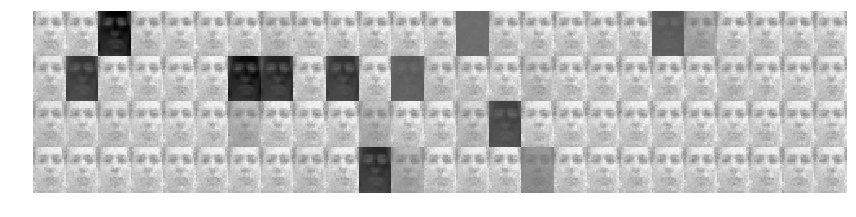

In [21]:
show_examples(outputs_val.reshape((-1, img_rows, img_cols)), n=100, n_cols=25)